#LaaR Loss as a Reward

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import json
import logging
import time
from collections import deque
from scipy.ndimage import zoom
from torchvision import datasets, transforms
import wandb

# ---------------------------
# Configuration Section
# ---------------------------
CONFIG = {
    # Logging and GPU settings
    "logging_level": logging.INFO,
    "cudnn_benchmark": True,

    # Data parameters
    "mnist_root": "./data",

    # Environment parameters
    "WINDOW_WIDTH": 4,
    "WINDOW_HEIGHT": 4,
    "MAX_MOVES": 10,
    "MAX_ZOOM_LEVEL": 7,
    "MIN_ZOOM_LEVEL": 1,
    "BASE_IMAGE_SIZE": 28,
    "initial_zoom_level": 7,
    "initial_window_position": (14, 14),

    # Decision Transformer parameters
    "d_model": 64,
    "nhead": 4,
    "num_layers": 2,
    "num_digit_classes": 10,
    "num_actions": 27,
    "seq_length": 10,

    # DT Agent parameters
    "movement_dim": 3,
    "vertical_actions": [-1, 0, 1],
    "horizontal_actions": [-1, 0, 1],
    "zoom_actions": [-1, 0, 1],

    # Training parameters
    "num_epochs": 30,  # Note: epoch 0 is used for ranking; training occurs for epochs >=1.
    "episodes_per_epoch": 6400,
    "batch_episodes": 128,
    "learning_rate": 0.001,
    "epsilon_const": 0.01,
    "dynamic_sampling_beta": 0.1,
    "use_curriculum": True,  # Enable curriculum learning
    "wandb_key": "",

    # Device
    "device": "cuda"
}

# ---------------------------
# Global Variables for Curriculum Learning
# ---------------------------
# Initially, all image difficulties are 1.0 (for dynamic sampling when curriculum is not used)
image_difficulties = np.ones(60000, dtype=np.float32)  # MNIST training size is 60000
# Will hold a stable ranked list (indices sorted from easiest to hardest)
ranked_indices = None

# ---------------------------
# Setup Logging and GPU Settings
# ---------------------------
logging.basicConfig(level=CONFIG["logging_level"],
                    format='%(asctime)s - %(levelname)s - %(message)s')
torch.backends.cudnn.benchmark = CONFIG["cudnn_benchmark"]

# ---------------------------
# Data Loading (MNIST)
# ---------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)

train_images = train_dataset.data.numpy().astype(np.float32) / 255.0
train_labels = train_dataset.targets.numpy()
test_images  = test_dataset.data.numpy().astype(np.float32) / 255.0
test_labels  = test_dataset.targets.numpy()

# ---------------------------
# Environment Class
# ---------------------------
class Environment:
    def __init__(self, images, labels, mode="train"):
        self.mode = mode  # "train" or "test"
        self.WINDOW_WIDTH = CONFIG["WINDOW_WIDTH"]
        self.WINDOW_HEIGHT = CONFIG["WINDOW_HEIGHT"]
        self.MAX_MOVES = CONFIG["MAX_MOVES"]
        self.MAX_ZOOM_LEVEL = CONFIG["MAX_ZOOM_LEVEL"]
        self.MIN_ZOOM_LEVEL = CONFIG["MIN_ZOOM_LEVEL"]
        self.BASE_IMAGE_SIZE = CONFIG["BASE_IMAGE_SIZE"]
        self.initial_zoom_level = CONFIG["initial_zoom_level"]
        self.initial_window_position = CONFIG["initial_window_position"]
        self.images = images
        self.labels = labels
        self.reset()

    def reset(self):
        global image_difficulties, ranked_indices
        if self.mode == "test":
            self.current_index = 0
        else:
            # Use curriculum ranking if available
            if CONFIG.get("use_curriculum", False) and ranked_indices is not None:
                N = len(ranked_indices)
                ranks = np.arange(N)
                uniform_prob = 1.0 / N
                linear_prob = (ranks + 1) / ((N * (N + 1)) / 2)
                p = 0.5 * uniform_prob + 0.5 * linear_prob
                p = p / p.sum()
                chosen_rank = np.random.choice(N, p=p)
                self.current_index = ranked_indices[chosen_rank]
            else:
                probabilities = image_difficulties / image_difficulties.sum()
                self.current_index = np.random.choice(len(self.images), p=probabilities)
        self.current_image = self.images[self.current_index]
        self.image_label = self.labels[self.current_index]
        self.num_moves = 0
        self.zoom_level = self.initial_zoom_level
        self.window_position = self.initial_window_position
        self.visited_positions = {}
        self.previous_view = None
        return self.get_state()

    def apply_zoom(self):
        step_size = (self.BASE_IMAGE_SIZE - CONFIG["WINDOW_WIDTH"]) / (self.MAX_ZOOM_LEVEL - self.MIN_ZOOM_LEVEL)
        window_size = CONFIG["WINDOW_WIDTH"] + int((self.zoom_level - 1) * step_size)
        return window_size

    def extract_window_view(self):
        window_size = self.apply_zoom()
        half_window = window_size // 2
        start_x = max(0, self.window_position[0] - half_window)
        end_x   = min(self.BASE_IMAGE_SIZE, start_x + window_size)
        start_y = max(0, self.window_position[1] - half_window)
        end_y   = min(self.BASE_IMAGE_SIZE, start_y + window_size)
        window_view = self.current_image[start_y:end_y, start_x:end_x]
        zoomed_view = zoom(window_view, (CONFIG["WINDOW_HEIGHT"] / window_view.shape[0],
                                         CONFIG["WINDOW_WIDTH"] / window_view.shape[1]), order=1)
        return zoomed_view

    def get_state(self):
        window_view = self.extract_window_view()
        state = np.concatenate([window_view.flatten(),
                                [self.zoom_level,
                                 self.window_position[0] - CONFIG["BASE_IMAGE_SIZE"] // 2,
                                 self.window_position[1] - CONFIG["BASE_IMAGE_SIZE"] // 2]])
        return state

    def move_window(self, vertical_move, horizontal_move):
        window_size = self.apply_zoom()
        new_x = self.window_position[0] + horizontal_move
        new_y = self.window_position[1] + vertical_move
        half_window = window_size // 2
        new_x = max(half_window, min(new_x, self.BASE_IMAGE_SIZE - half_window))
        new_y = max(half_window, min(new_y, self.BASE_IMAGE_SIZE - half_window))
        self.window_position = (new_x, new_y)

    def step(self, action):
        vertical_move, horizontal_move, zoom_action = action
        self.zoom_level = max(self.MIN_ZOOM_LEVEL,
                              min(self.MAX_ZOOM_LEVEL, self.zoom_level * (2 ** zoom_action)))
        self.move_window(vertical_move, horizontal_move)
        new_state = self.get_state()
        self.num_moves += 1
        done = self.num_moves >= self.MAX_MOVES
        return new_state, done, self.image_label

# ---------------------------
# Decision Transformer Model (PyTorch)
# ---------------------------
class DecisionTransformer(nn.Module):
    def __init__(self, token_dim):
        super(DecisionTransformer, self).__init__()
        self.token_dim = token_dim
        self.d_model = CONFIG["d_model"]
        self.seq_length = CONFIG["seq_length"]

        self.input_proj = nn.Linear(token_dim, self.d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(self.seq_length, self.d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=CONFIG["nhead"])
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=CONFIG["num_layers"])
        self.digit_head = nn.Linear(self.d_model, CONFIG["num_digit_classes"])
        self.movement_head = nn.Linear(self.d_model, CONFIG["num_actions"])

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        x = self.input_proj(x)
        pos_emb = self.pos_embedding.unsqueeze(0).expand(batch_size, -1, -1)
        x = x + pos_emb
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        digit_logits = self.digit_head(x)
        movement_q   = self.movement_head(x)
        return digit_logits, movement_q

# ---------------------------
# DT Agent
# ---------------------------
class DTAgent:
    def __init__(self, state_size, device):
        self.token_dim = state_size + CONFIG["movement_dim"] + 1
        self.seq_length = CONFIG["seq_length"]
        self.num_actions = CONFIG["num_actions"]
        self.device = device

        self.model = DecisionTransformer(token_dim=self.token_dim).to(device)
        if torch.cuda.device_count() > 1:
            logging.info(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
            self.model = nn.DataParallel(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), lr=CONFIG["learning_rate"])

        self.vertical_actions = CONFIG["vertical_actions"]
        self.horizontal_actions = CONFIG["horizontal_actions"]
        self.zoom_actions = CONFIG["zoom_actions"]
        self.action_space = [(v, h, z) for v in self.vertical_actions
                                         for h in self.horizontal_actions
                                         for z in self.zoom_actions]

    def select_action(self, token_sequence):
        self.model.eval()
        with torch.no_grad():
            digit_logits, movement_q = self.model(token_sequence)
        last_movement_q = movement_q[0, -1]
        action_index = torch.argmax(last_movement_q).item()
        action = self.action_space[action_index]

        last_digit_logits = digit_logits[0, -1]
        digit_probs = F.softmax(last_digit_logits, dim=-1)
        predicted_digit = torch.argmax(digit_probs).item()
        return action, predicted_digit, last_digit_logits, action_index, last_movement_q[action_index].item()

    def update_with_episode(self, token_sequence, target_digit_labels, action_indices, target_rewards):
        self.model.train()
        digit_logits, movement_q = self.model(token_sequence)
        digit_logits_flat = digit_logits.view(-1, digit_logits.size(-1))
        target_digit_flat = target_digit_labels.view(-1).to(self.device)
        digit_loss = F.cross_entropy(digit_logits_flat, target_digit_flat)

        batch, seq_len, _ = movement_q.size()
        movement_q_flat = movement_q.view(-1, movement_q.size(-1))
        action_indices_flat = action_indices.view(-1).to(self.device)
        predicted_rewards = movement_q_flat[torch.arange(batch * seq_len), action_indices_flat]
        target_rewards_flat = target_rewards.view(-1).to(self.device)
        movement_loss = F.mse_loss(predicted_rewards, target_rewards_flat)
        loss = digit_loss + movement_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item(), digit_loss.item(), movement_loss.item()

# ---------------------------
# Episode Simulation Functions
# ---------------------------
def run_episode(env, agent, state_size, return_avg_loss=False, is_ranking=False):
    state = env.reset()
    init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
    tokens = [init_token]
    label = env.image_label
    target_digit_labels = [label]
    action_indices = []
    reward_targets = []
    cumulative_reward = 0.0

    episode_losses = []

    for t in range(CONFIG["seq_length"]):
        current_seq = tokens.copy()
        while len(current_seq) < CONFIG["seq_length"]:
            current_seq.append(current_seq[-1])
        token_seq_tensor = torch.tensor(np.array(current_seq), dtype=torch.float32).unsqueeze(0).to(agent.device)
        action, predicted_digit, digit_logits, action_index, predicted_reward = agent.select_action(token_seq_tensor)
        new_state, done, gt_label = env.step(action)

        target_tensor = torch.tensor([gt_label], dtype=torch.long).to(agent.device)
        L = F.cross_entropy(digit_logits.unsqueeze(0), target_tensor)
        episode_losses.append(L.item())

        R_target = 1.0 / (1.0 + L.item() + CONFIG["epsilon_const"])
        cumulative_reward += R_target

        movement_array = np.array(action, dtype=np.float32)
        reward_array = np.array([R_target], dtype=np.float32)
        new_token = np.concatenate([new_state, movement_array, reward_array])
        tokens.append(new_token)
        target_digit_labels.append(gt_label)
        action_indices.append(action_index)
        reward_targets.append(R_target)
        if done:
            break

    tokens = tokens[:CONFIG["seq_length"]]
    target_digit_labels = target_digit_labels[:CONFIG["seq_length"]]
    if len(action_indices) < CONFIG["seq_length"]:
        last_action = action_indices[-1] if action_indices else 0
        last_reward = reward_targets[-1] if reward_targets else 0.0
        pad_length = CONFIG["seq_length"] - len(action_indices)
        action_indices.extend([last_action] * pad_length)
        reward_targets.extend([last_reward] * pad_length)

    token_seq = torch.tensor(np.array(tokens), dtype=torch.float32).unsqueeze(0).to(agent.device)
    target_digit_labels_tensor = torch.tensor(np.array(target_digit_labels), dtype=torch.long).unsqueeze(0).to(agent.device)
    action_indices_tensor = torch.tensor(np.array(action_indices), dtype=torch.long).unsqueeze(0).to(agent.device)
    reward_targets_tensor = torch.tensor(np.array(reward_targets), dtype=torch.float32).unsqueeze(0).to(agent.device)

    if episode_losses and not is_ranking:
        avg_loss = sum(episode_losses) / len(episode_losses)
        global image_difficulties
        beta = CONFIG["dynamic_sampling_beta"]
        image_difficulties[env.current_index] = beta * avg_loss + (1 - beta) * image_difficulties[env.current_index]
    else:
        avg_loss = sum(episode_losses) / len(episode_losses) if episode_losses else 0.0

    if return_avg_loss:
        return token_seq, target_digit_labels_tensor, action_indices_tensor, reward_targets_tensor, cumulative_reward, avg_loss
    else:
        return token_seq, target_digit_labels_tensor, action_indices_tensor, reward_targets_tensor, cumulative_reward

def run_batch_episodes(envs, agent, state_size):
    batch_tokens = []
    batch_digit_labels = []
    batch_action_indices = []
    batch_reward_targets = []
    batch_rewards = []

    for env in envs:
        token_seq, target_digit_labels, action_indices, reward_targets, ep_reward = run_episode(env, agent, state_size)
        batch_tokens.append(token_seq.squeeze(0))
        batch_digit_labels.append(target_digit_labels.squeeze(0))
        batch_action_indices.append(action_indices.squeeze(0))
        batch_reward_targets.append(reward_targets.squeeze(0))
        batch_rewards.append(ep_reward)

    token_seq_batch = torch.stack(batch_tokens, dim=0)
    target_digit_labels_batch = torch.stack(batch_digit_labels, dim=0)
    action_indices_batch = torch.stack(batch_action_indices, dim=0)
    reward_targets_batch = torch.stack(batch_reward_targets, dim=0)
    avg_reward = np.mean(batch_rewards)
    return token_seq_batch, target_digit_labels_batch, action_indices_batch, reward_targets_batch, avg_reward

# ---------------------------
# Parallel Curriculum Ranking Phase Function
# ---------------------------
def compute_initial_state(img):
    """
    Mimics Environment.get_state() for a given image using the initial settings.
    Returns a state vector of dimension 19.
    """
    BASE_IMAGE_SIZE = CONFIG["BASE_IMAGE_SIZE"]
    WINDOW_WIDTH = CONFIG["WINDOW_WIDTH"]
    WINDOW_HEIGHT = CONFIG["WINDOW_HEIGHT"]
    MAX_ZOOM_LEVEL = CONFIG["MAX_ZOOM_LEVEL"]
    MIN_ZOOM_LEVEL = CONFIG["MIN_ZOOM_LEVEL"]
    initial_zoom_level = CONFIG["initial_zoom_level"]
    initial_window_position = CONFIG["initial_window_position"]

    step_size = (BASE_IMAGE_SIZE - WINDOW_WIDTH) / (MAX_ZOOM_LEVEL - MIN_ZOOM_LEVEL)
    window_size = WINDOW_WIDTH + int((initial_zoom_level - 1) * step_size)
    half_window = window_size // 2
    start_x = max(0, initial_window_position[0] - half_window)
    end_x = min(BASE_IMAGE_SIZE, start_x + window_size)
    start_y = max(0, initial_window_position[1] - half_window)
    end_y = min(BASE_IMAGE_SIZE, start_y + window_size)

    window_view = img[start_y:end_y, start_x:end_x]
    # Zoom the window view to (WINDOW_HEIGHT, WINDOW_WIDTH)
    zoomed_view = zoom(window_view, (WINDOW_HEIGHT / window_view.shape[0],
                                     WINDOW_WIDTH / window_view.shape[1]), order=1)
    # Construct state: flattened zoomed view + [zoom_level, window_offset_x, window_offset_y]
    state = np.concatenate([
        zoomed_view.flatten(),
        np.array([initial_zoom_level,
                  initial_window_position[0] - BASE_IMAGE_SIZE // 2,
                  initial_window_position[1] - BASE_IMAGE_SIZE // 2], dtype=np.float32)
    ])
    return state

def curriculum_ranking_phase_parallel(agent, state_size, batch_size=256):
    global image_difficulties, ranked_indices
    logging.info("Starting parallel curriculum ranking phase (Epoch 0)")
    agent.model.eval()

    num_images = len(train_images)
    token_dim = state_size + CONFIG["movement_dim"] + 1  # should be 19+3+1 = 23
    seq_length = CONFIG["seq_length"]

    # Use compute_initial_state to match Environment.get_state()
    states = np.array([compute_initial_state(img) for img in train_images], dtype=np.float32)
    # Create initial token for each image by concatenating zeros for movement and reward.
    init_tokens = np.concatenate([
        states,
        np.zeros((num_images, CONFIG["movement_dim"] + 1), dtype=np.float32)
    ], axis=1)  # Shape: (num_images, token_dim)

    # Repeat the initial token to form a sequence.
    token_sequences = np.repeat(init_tokens[:, np.newaxis, :], seq_length, axis=1)  # (num_images, seq_length, token_dim)
    token_sequences = torch.tensor(token_sequences, dtype=torch.float32).to(agent.device)

    # Ground truth labels for all training images.
    labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(agent.device)

    ranking_losses = np.zeros(num_images, dtype=np.float32)
    num_batches = (num_images + batch_size - 1) // batch_size

    with torch.no_grad():
        for b in range(num_batches):
            start = b * batch_size
            end = min(num_images, (b + 1) * batch_size)
            batch_tokens = token_sequences[start:end]  # (batch, seq_length, token_dim)
            batch_labels = labels_tensor[start:end]      # (batch,)
            digit_logits, _ = agent.model(batch_tokens)
            last_logits = digit_logits[:, -1, :]  # (batch, num_digit_classes)
            losses = F.cross_entropy(last_logits, batch_labels, reduction='none')
            ranking_losses[start:end] = losses.cpu().numpy()
            if b % 10 == 0:
                logging.info(f"Processed batch {b+1}/{num_batches}")

    image_difficulties = ranking_losses.copy()
    ranked_indices = np.argsort(image_difficulties)
    logging.info("Parallel curriculum ranking phase completed.")
    logging.info(f"Easiest image loss: {image_difficulties[ranked_indices[0]]:.4f}, "
                 f"Hardest image loss: {image_difficulties[ranked_indices[-1]]:.4f}")


# ---------------------------
# Training Function
# ---------------------------
def train_experiment():
    wandb.login(key=CONFIG["wandb_key"])
    wandb.init(
        project="EyeLaaR",
        config={
            "num_epochs": CONFIG["num_epochs"],
            "episodes_per_epoch": CONFIG["episodes_per_epoch"],
            "batch_episodes": CONFIG["batch_episodes"],
            "learning_rate": CONFIG["learning_rate"],
            "seq_length": CONFIG["seq_length"]
        }
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env_for_state = Environment(train_images, train_labels)
    state_size = env_for_state.get_state().shape[0]
    agent = DTAgent(state_size=state_size, device=device)
    logging.info("DTAgent created successfully")

    total_steps = 0
    training_stats = []
    num_batches = CONFIG["episodes_per_epoch"] // CONFIG["batch_episodes"]

    # ---------------------------
    # Parallel Curriculum Ranking Phase (Epoch 0)
    # ---------------------------
    if CONFIG.get("use_curriculum", False):
        curriculum_ranking_phase_parallel(agent, state_size)

    # ---------------------------
    # Main Training Loop (Epochs >= 1)
    # ---------------------------
    for epoch in range(1, CONFIG["num_epochs"]):
        epoch_loss = 0.0
        epoch_digit_loss = 0.0
        epoch_movement_loss = 0.0
        epoch_reward = 0.0

        for b in range(num_batches):
            start_time = time.time()
            envs = [Environment(train_images, train_labels) for _ in range(CONFIG["batch_episodes"])]
            token_seq_batch, digit_labels_batch, action_indices_batch, reward_targets_batch, avg_reward = run_batch_episodes(
                envs, agent, state_size
            )
            loss, d_loss, m_loss = agent.update_with_episode(token_seq_batch, digit_labels_batch,
                                                            action_indices_batch, reward_targets_batch)
            batch_time = time.time() - start_time

            epoch_loss += loss
            epoch_digit_loss += d_loss
            epoch_movement_loss += m_loss
            epoch_reward += avg_reward

            wandb.log({
                "batch_loss": loss,
                "batch_digit_loss": d_loss,
                "batch_movement_loss": m_loss,
                "batch_avg_reward": avg_reward,
                "batch_time": batch_time,
                "global_step": total_steps,
                "epoch": epoch
            })

            logging.info(f"Epoch {epoch} Batch {b+1}/{num_batches}: "
                        f"Loss={loss:.3f}, DigitLoss={d_loss:.3f}, MovLoss={m_loss:.3f}, "
                        f"AvgReward={avg_reward:.3f}, Time={batch_time:.2f}s")

        avg_epoch_loss = epoch_loss / num_batches
        avg_epoch_digit_loss = epoch_digit_loss / num_batches
        avg_epoch_movement_loss = epoch_movement_loss / num_batches
        avg_epoch_reward = epoch_reward / num_batches

        logging.info(f"Epoch {epoch} Summary: AvgLoss={avg_epoch_loss:.3f}, "
                    f"AvgDigitLoss={avg_epoch_digit_loss:.3f}, AvgMovLoss={avg_epoch_movement_loss:.3f}, "
                    f"AvgReward={avg_epoch_reward:.3f}")

        wandb.log({
            "epoch_avg_loss": avg_epoch_loss,
            "epoch_avg_digit_loss": avg_epoch_digit_loss,
            "epoch_avg_movement_loss": avg_epoch_movement_loss,
            "epoch_avg_reward": avg_epoch_reward,
            "epoch": epoch
        })
        training_stats.append({
            "epoch": epoch,
            "avg_loss": avg_epoch_loss,
            "avg_digit_loss": avg_epoch_digit_loss,
            "avg_movement_loss": avg_epoch_movement_loss,
            "avg_reward": avg_epoch_reward
        })

        # Save the model weights after this epoch
        torch.save(agent.model.state_dict(), f"dt_model_weights_epoch_{epoch}.pth")
        logging.info(f"Saved model weights for epoch {epoch}.")


    with open("training_stats.json", "w") as f:
        json.dump(training_stats, f, indent=4)
    torch.save(agent.model.state_dict(), "dt_model_weights.pth")
    logging.info("Training completed and data saved.")
    wandb.finish()

if __name__ == '__main__':
    train_experiment()


100%|██████████| 9.91M/9.91M [00:00<00:00, 49.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.74MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.72MB/s]
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:


Abort: 

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F
import random

# ---------------------------
# Batch Evaluation Function
# ---------------------------
def run_batch_episode_eval(envs, agent, state_size,
                           seq_length=CONFIG["seq_length"],
                           epsilon_const=CONFIG["epsilon_const"]):
    """
    Run evaluation episodes in parallel.
    Each environment in envs is assumed to be set up for a single test image.
    Returns lists of predicted digits, true labels, and image IDs.
    """
    batch_size = len(envs)
    # Initialize per-environment token sequences, labels, and image IDs.
    tokens_batch = []
    labels_batch = []
    image_ids_batch = []
    for env in envs:
        state = env.reset()  # In test mode, reset simply returns the test image state.
        # For the initial token, append zeros for movement (3) and reward (1).
        init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
        tokens_batch.append([init_token])
        labels_batch.append(env.image_label)
        image_ids_batch.append(env.current_index)

    # For recording final predicted digit per episode.
    predicted_digits = [None] * batch_size

    # Run for exactly seq_length steps.
    for t in range(seq_length):
        current_batch = []
        # Ensure each token sequence is exactly `seq_length` in length by taking the last tokens.
        for tokens in tokens_batch:
            if len(tokens) < seq_length:
                padded_tokens = tokens + [tokens[-1]] * (seq_length - len(tokens))
            else:
                padded_tokens = tokens[-seq_length:]
            current_batch.append(padded_tokens)
        token_seq_batch = torch.tensor(np.array(current_batch), dtype=torch.float32).to(agent.device)  # (batch, seq_length, token_dim)

        # Forward pass for the whole batch.
        agent.model.eval()
        with torch.no_grad():
            digit_logits, movement_q = agent.model(token_seq_batch)
        # Use outputs at the last time step.
        last_movement_q = movement_q[:, -1, :]  # shape: (batch, num_actions)
        last_digit_logits = digit_logits[:, -1, :]  # shape: (batch, num_digit_classes)

        # Use a greedy policy (choose argmax).
        actions = []
        for i in range(batch_size):
            action_index = torch.argmax(last_movement_q[i]).item()
            action = agent.action_space[action_index]
            actions.append(action)
            predicted_digit = torch.argmax(F.softmax(last_digit_logits[i], dim=-1)).item()
            predicted_digits[i] = predicted_digit

        # Update each environment with its chosen action and append the new token.
        for i, env in enumerate(envs):
            new_state, done, _ = env.step(actions[i])
            # Use the Q-value corresponding to the chosen action as a proxy reward.
            predicted_reward = last_movement_q[i, torch.argmax(last_movement_q[i]).item()].item()
            movement_array = np.array(actions[i], dtype=np.float32)
            reward_array = np.array([predicted_reward], dtype=np.float32)
            new_token = np.concatenate([new_state, movement_array, reward_array])
            tokens_batch[i].append(new_token)
    return predicted_digits, labels_batch, image_ids_batch

# ---------------------------
# Evaluation Function
# ---------------------------
def evaluate_accuracy(batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load MNIST test dataset using CONFIG variables.
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images = test_dataset.data.numpy().astype(np.float32) / 255.0
    test_labels = test_dataset.targets.numpy()

    # Create a list of environments—one per test image.
    # Here we pass mode="test" so that the Environment uses deterministic sampling.
    test_envs = []
    for i in range(len(test_images)):
        env = Environment(test_images[i:i+1], test_labels[i:i+1], mode="test")
        test_envs.append(env)

    state_size = test_envs[0].get_state().shape[0]
    seq_length = CONFIG["seq_length"]  # Use the same sequence length as in training.

    # Initialize the DTAgent with the correct state size and load trained weights.
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy evaluation

    total = len(test_envs)
    correct = 0
    all_predicted = []
    all_labels = []

    # Process the test environments in batches.
    for i in range(0, total, batch_size):
        batch_envs = test_envs[i:i+batch_size]
        predicted_digits, labels, image_ids = run_batch_episode_eval(batch_envs, agent, state_size, seq_length=seq_length)
        for pred, label in zip(predicted_digits, labels):
            all_predicted.append(pred)
            all_labels.append(label)
            if pred == label:
                correct += 1

    accuracy = correct / total
    print(f"Evaluated {total} test images.")
    print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
    return accuracy

if __name__ == "__main__":
    evaluate_accuracy(batch_size=64)


Evaluated 10000 test images.
Accuracy: 0.8666 (86.66%)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 Accuracy: 0.1135
Epoch 2 Accuracy: 0.3055
Epoch 3 Accuracy: 0.3688
Epoch 4 Accuracy: 0.4190
Epoch 5 Accuracy: 0.5863
Epoch 6 Accuracy: 0.6915
Epoch 7 Accuracy: 0.7596
Epoch 8 Accuracy: 0.7758
Epoch 9 Accuracy: 0.7509
Epoch 10 Accuracy: 0.7265
Epoch 11 Accuracy: 0.8198
Epoch 12 Accuracy: 0.7669
Epoch 13 Accuracy: 0.7980
Epoch 14 Accuracy: 0.8529
Epoch 15 Accuracy: 0.8326
Epoch 16 Accuracy: 0.8112
Epoch 17 Accuracy: 0.8493
Epoch 18 Accuracy: 0.8542
Epoch 19 Accuracy: 0.8506
Epoch 20 Accuracy: 0.8371
Epoch 21 Accuracy: 0.8299
Epoch 22 Accuracy: 0.7886
Epoch 23 Accuracy: 0.8427
Epoch 24 Accuracy: 0.8182
Epoch 25 Accuracy: 0.7727
Epoch 26 Accuracy: 0.8407
Epoch 27 Accuracy: 0.8417
Epoch 28 Accuracy: 0.8281
Epoch 29 Accuracy: 0.8666


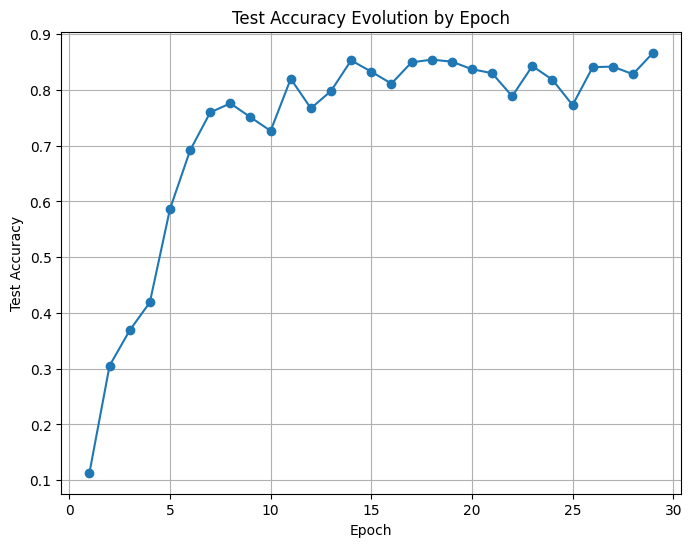

In [ ]:
import matplotlib.pyplot as plt

def evaluate_accuracy_from_weight(weight_file, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the MNIST test dataset.
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images = test_dataset.data.numpy().astype(np.float32) / 255.0
    test_labels = test_dataset.targets.numpy()

    # Create one test environment per image.
    test_envs = []
    for i in range(len(test_images)):
        env = Environment(test_images[i:i+1], test_labels[i:i+1], mode="test")
        test_envs.append(env)

    # Get the state size from an environment.
    state_size = test_envs[0].get_state().shape[0]
    seq_length = CONFIG["seq_length"]

    # Initialize the DTAgent and load the provided weights.
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load(weight_file, map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy evaluation

    total = len(test_envs)
    correct = 0

    # Process the test environments in batches.
    for i in range(0, total, batch_size):
        batch_envs = test_envs[i:i+batch_size]
        predicted_digits, labels, _ = run_batch_episode_eval(batch_envs, agent, state_size, seq_length=seq_length)
        for pred, label in zip(predicted_digits, labels):
            if pred == label:
                correct += 1

    accuracy = correct / total
    return accuracy

# Evaluate accuracy for each epoch.
accuracies = []
epoch_numbers = list(range(1, CONFIG["num_epochs"]))  # Assuming epochs start at 1.
for epoch in epoch_numbers:
    weight_file = f"dt_model_weights_epoch_{epoch}.pth"
    acc = evaluate_accuracy_from_weight(weight_file, batch_size=64)
    accuracies.append(acc)
    print(f"Epoch {epoch} Accuracy: {acc:.4f}")

# Plot the evolution of accuracy over epochs.
plt.figure(figsize=(8, 6))
plt.plot(epoch_numbers, accuracies, marker='o')
plt.title("Test Accuracy Evolution by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


Selected random test image index: 1581


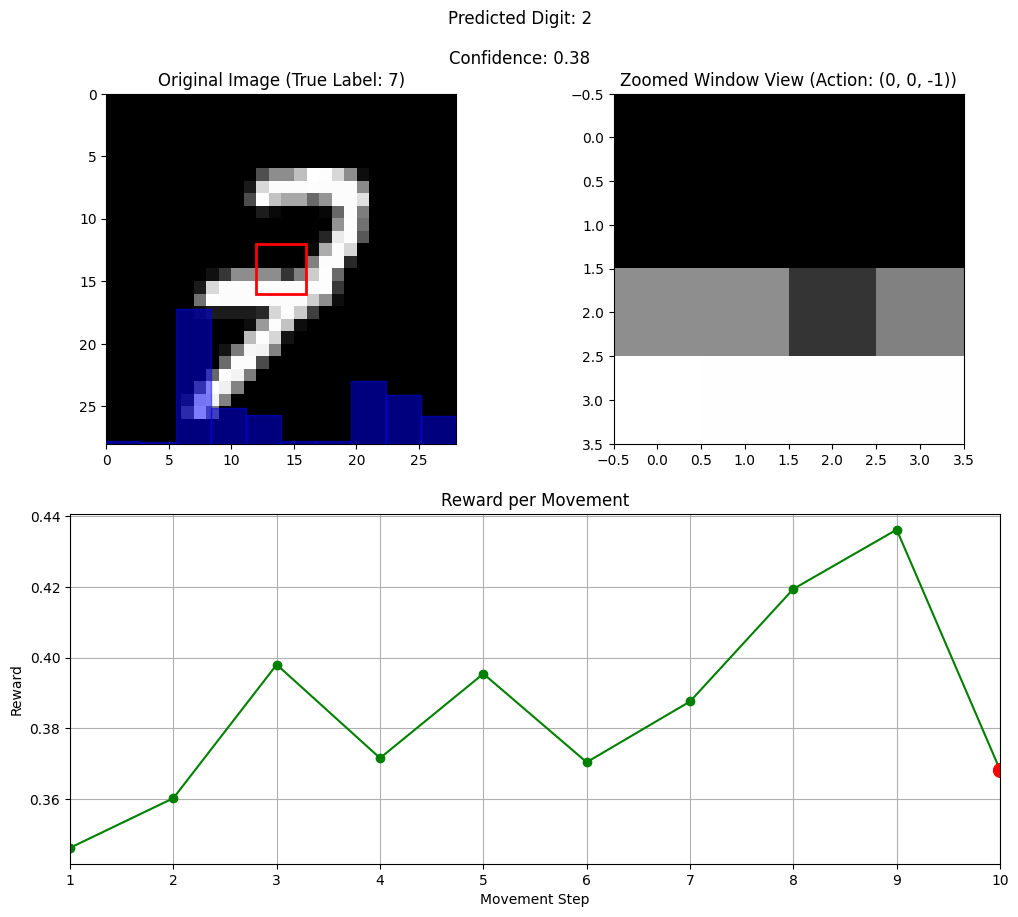

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torchvision import datasets, transforms
from matplotlib.animation import FFMpegWriter
import torch
import torch.nn.functional as F

# Assume CONFIG, Environment, DTAgent, and DecisionTransformer are defined and imported.

def run_episode_eval(env, agent, state_size,
                     seq_length=CONFIG["seq_length"],
                     epsilon_const=CONFIG["epsilon_const"],
                     episode_id=100):
    """
    Runs one evaluation episode and records states, actions, prediction probabilities, and rewards.
    Returns a dictionary with episode data.
    """
    state = env.reset()
    image_id = env.current_index  # record image index
    # For the first token, use zeros for movement (3) and reward (1)
    init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
    tokens = [init_token]
    states_record = [state.tolist()]
    actions_record = []
    prediction_probs_record = []
    rewards_record = []  # record predicted reward per movement
    label = env.image_label
    predicted_digit = None

    for t in range(seq_length):
        # Pad the token sequence to length=seq_length
        current_seq = tokens.copy()
        while len(current_seq) < seq_length:
            current_seq.append(current_seq[-1])
        token_seq_tensor = torch.tensor(np.array(current_seq), dtype=torch.float32)\
                              .unsqueeze(0).to(agent.device)
        action, predicted_digit, digit_logits, action_index, predicted_reward = agent.select_action(token_seq_tensor)
        new_state, done, gt_label = env.step(action)

        # Get prediction probabilities from the digit head
        digit_probs = F.softmax(digit_logits, dim=-1).cpu().detach().numpy().tolist()

        states_record.append(new_state.tolist())
        actions_record.append(action)
        prediction_probs_record.append(digit_probs)
        rewards_record.append(predicted_reward)  # record the reward for this movement

        # Create new token: new_state + action (3 values) + predicted reward (1 value)
        movement_array = np.array(action, dtype=np.float32)
        reward_array = np.array([predicted_reward], dtype=np.float32)
        new_token = np.concatenate([new_state, movement_array, reward_array])
        tokens.append(new_token)

        if done:
            break

    # Ensure records have exactly seq_length entries where needed
    while len(states_record) < seq_length + 1:
        states_record.append(states_record[-1])
    while len(actions_record) < seq_length:
        actions_record.append(actions_record[-1])
    while len(prediction_probs_record) < seq_length:
        prediction_probs_record.append(prediction_probs_record[-1])
    while len(rewards_record) < seq_length:
        rewards_record.append(rewards_record[-1])

    episode_data = {
        'predicted_digit': predicted_digit,
        'true_label': label,
        'states': states_record,           # length: seq_length+1 (initial state + steps)
        'actions': actions_record,         # length: seq_length
        'prediction_probs': prediction_probs_record,  # length: seq_length
        'rewards': rewards_record,         # list of rewards per movement
        'image_id': image_id,
        'episode': episode_id
    }
    return episode_data

def visualize_episode(episode_data, test_images):
    """
    Visualizes a single episode.
    Expects episode_data to have keys: 'image_id', 'states', 'actions', 'true_label',
    'prediction_probs', 'rewards', 'predicted_digit', and 'episode'.
    """
    image_id = episode_data['image_id']
    states = episode_data['states']
    actions = episode_data['actions']
    true_label = episode_data['true_label']
    prediction_probs = episode_data['prediction_probs']
    rewards = episode_data['rewards']
    predicted_digit = episode_data['predicted_digit']

    # Final confidence is the maximum probability from the last time step.
    final_confidence = max(prediction_probs[-1])
    image = test_images[image_id]  # Test images are assumed in the range [0,1]

    # Set up the figure with three subplots:
    # - ax1: Original image with an inset bar chart for digit probabilities.
    # - ax2: Zoomed window view.
    # - ax3: Reward per movement plot.
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    base_size = CONFIG["BASE_IMAGE_SIZE"]
    ax1.imshow(image, cmap='gray', extent=[0, base_size, base_size, 0])
    ax1.set_title(f"Original Image (True Label: {true_label})")

    # Create an inset axis on ax1 for the probability bar chart.
    prob_ax = ax1.inset_axes([0, 0, 1, 1])
    prob_ax.set_xlim(0, 10)
    prob_ax.set_ylim(0, 1)
    prob_ax.axis('off')

    # Calculate bar width so that 10 bars fit in the image width.
    bar_width = 1
    bar_container = prob_ax.bar(
        np.arange(10) * bar_width + bar_width/2,
        np.zeros(10),
        width=bar_width,
        align='center',
        alpha=0.5
    )

    ax2.set_title("Zoomed Window View")
    ax3.set_title("Reward per Movement")
    ax3.set_xlabel("Movement Step")
    ax3.set_ylabel("Reward")

    # Display final predicted digit and confidence at the top of the figure.
    fig.text(0.5, 0.95, f'Predicted Digit: {predicted_digit}', ha='center', fontsize=12)
    fig.text(0.5, 0.91, f'Confidence: {final_confidence:.2f}', ha='center', fontsize=12)

    def animate(i):
        # Update the zoomed view subplot and rectangle on original image.
        state = np.array(states[i+1])
        action = actions[i]
        # Assuming that the zoom level is stored at index 16 (after the 4x4 window view)
        zoom_level = state[16] if len(state) > 16 else 1  # fallback in case of different state size
        probs = prediction_probs[i]

        # Update zoomed view (first 16 values form a 4x4 window view)
        ax2.cla()
        window_view = state[:16].reshape((4, 4))
        ax2.imshow(window_view, cmap='gray', interpolation='nearest')
        ax2.set_title(f"Zoomed Window View (Action: {action})")

        # Remove previous rectangle annotations from ax1.
        for patch in reversed(ax1.patches):
            patch.remove()

        # Draw rectangle on the original image to indicate the zoom window.
        rect_width = rect_height = 4 * zoom_level
        center = base_size // 2
        # Last two values in state vector indicate window offset (from center)
        x_offset = state[-2]
        y_offset = state[-1]
        x_pos = center + x_offset - rect_width / 2
        y_pos = center + y_offset - rect_height / 2
        rect = plt.Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        # Update the probability bars in the inset axis.
        for bar, height in zip(bar_container, probs):
            bar.set_height(height)
            bar.set_color('blue')

        # Update reward per movement plot:
        ax3.cla()
        steps = np.arange(1, len(rewards) + 1)
        ax3.plot(steps, rewards, marker='o', color='green')
        ax3.set_title("Reward per Movement")
        ax3.set_xlabel("Movement Step")
        ax3.set_ylabel("Reward")
        ax3.set_xlim(1, len(rewards))
        # Highlight the current step's reward
        current_reward = rewards[i]
        ax3.plot(i+1, current_reward, marker='o', markersize=10, color='red')
        ax3.grid(True)
        return []

    ani = animation.FuncAnimation(fig, animate, frames=len(actions), interval=500, blit=False, repeat=False)
    writer = FFMpegWriter(fps=2, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f"episode_{episode_data['episode']}_visualization.mp4", writer=writer)
    plt.show()

def main():
    # Load MNIST test dataset using CONFIG values.
    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images_all = test_dataset.data.numpy().astype(np.float32) / 255.0

    # Randomly select a test image from the full test set.
    import random  # ensure random is imported if not already
    random_idx = random.randrange(len(test_dataset))
    print(f"Selected random test image index: {random_idx}")
    test_image = test_images_all[random_idx:random_idx+1]  # slice a single image
    test_label = test_dataset.targets.numpy()[random_idx:random_idx+1]

    # Create a test environment with just this single test image in test mode.
    test_env = Environment(test_image, test_label, mode="test")
    state_size = test_env.get_state().shape[0]
    seq_length = CONFIG["seq_length"]

    # Initialize DTAgent and load trained model weights.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy for evaluation

    # Run one evaluation episode.
    episode_data = run_episode_eval(test_env, agent, state_size, seq_length=seq_length, episode_id=0)

    # Visualize the episode.
    # Note: Since our environment now contains only one image, pass test_image directly.
    visualize_episode(episode_data, test_image)

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Selected test image index: 37


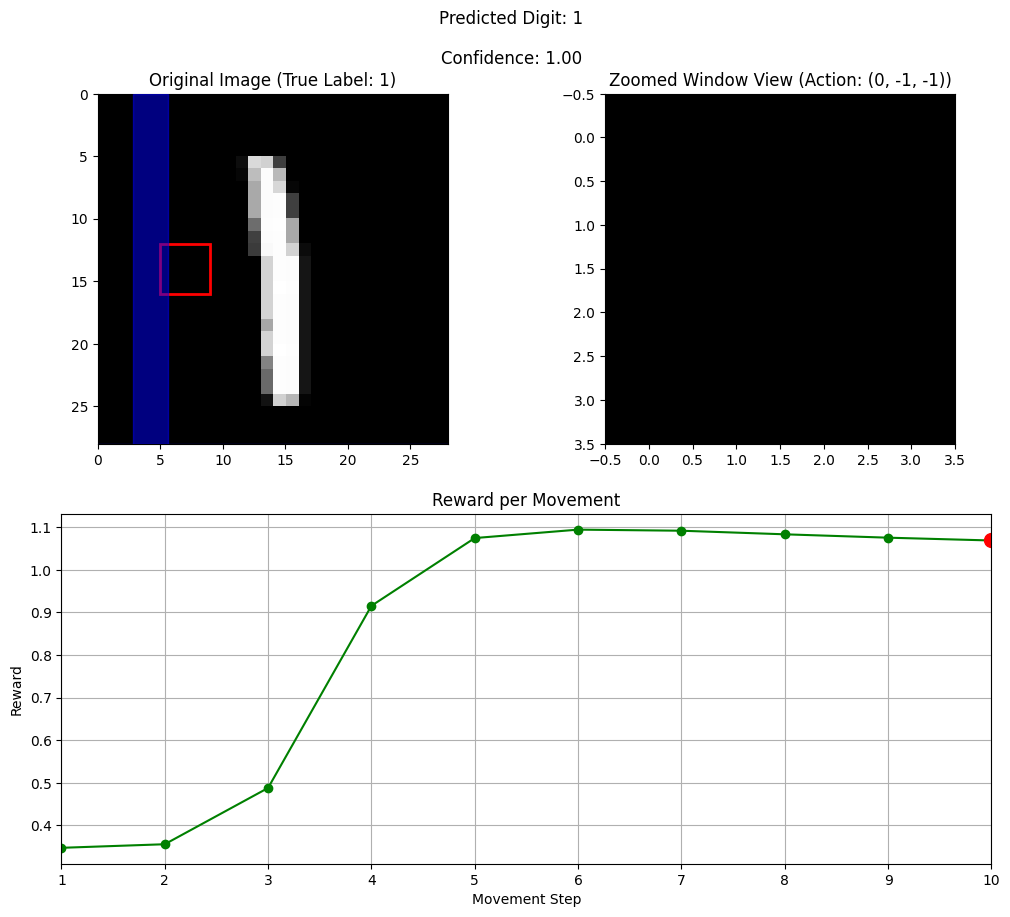

Selected test image index: 3117


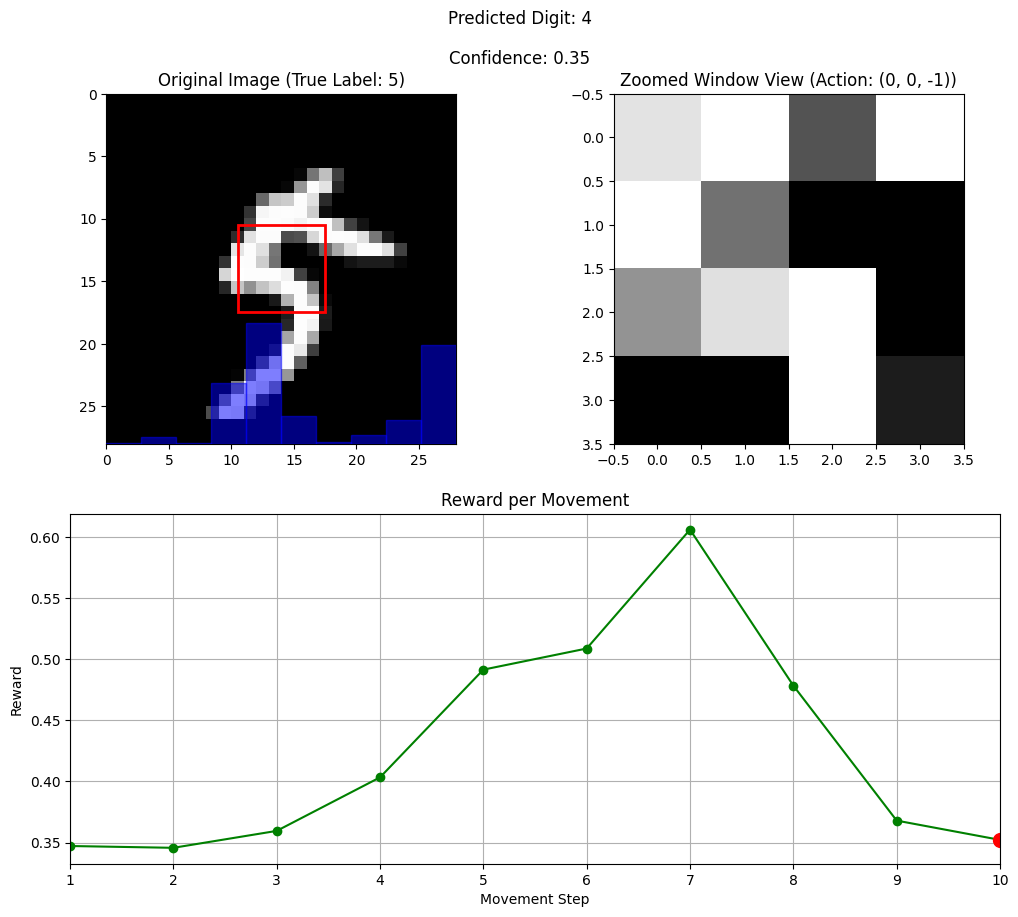

Selected test image index: 12


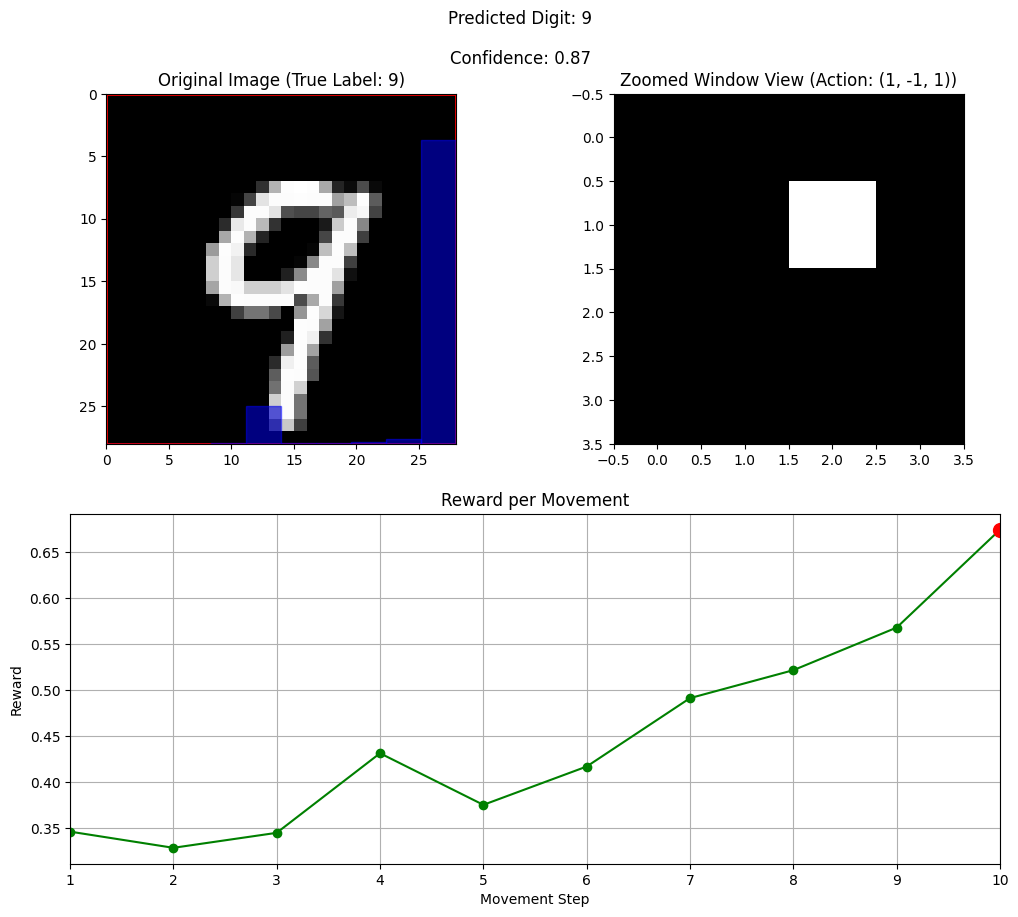

Selected test image index: 2035


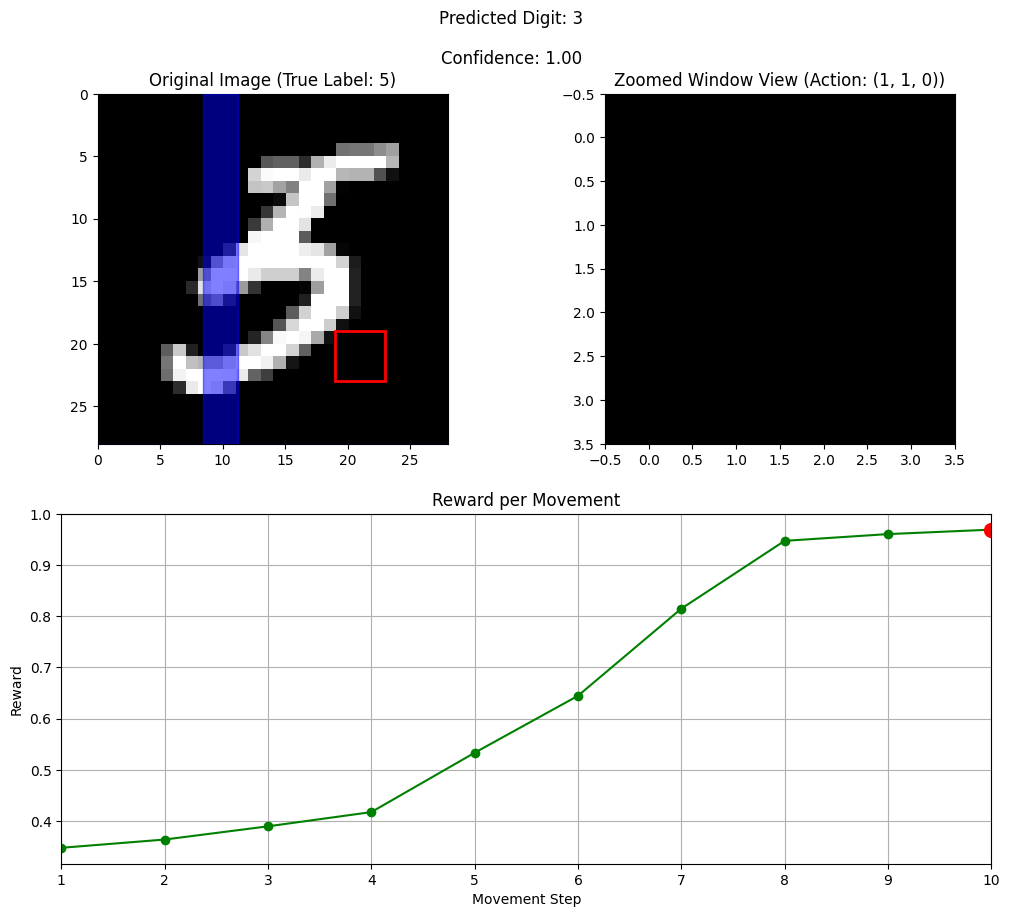

Selected test image index: 6151


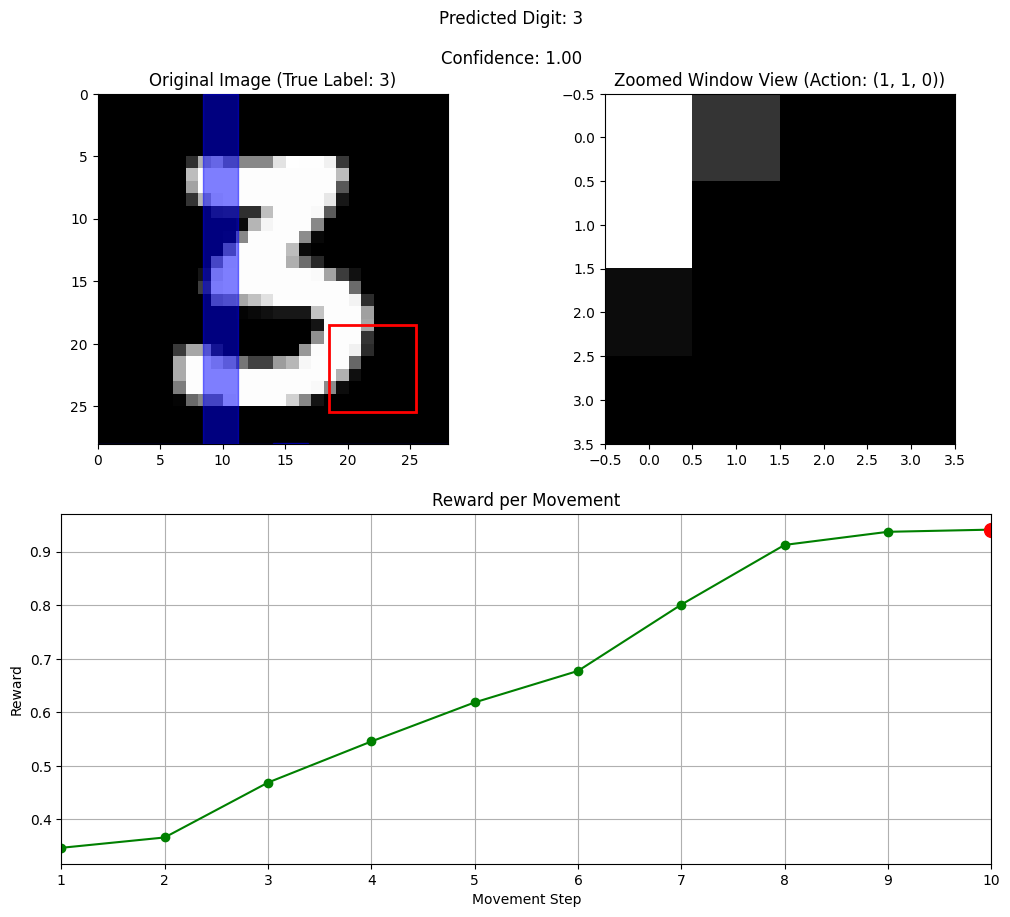

Selected test image index: 8918


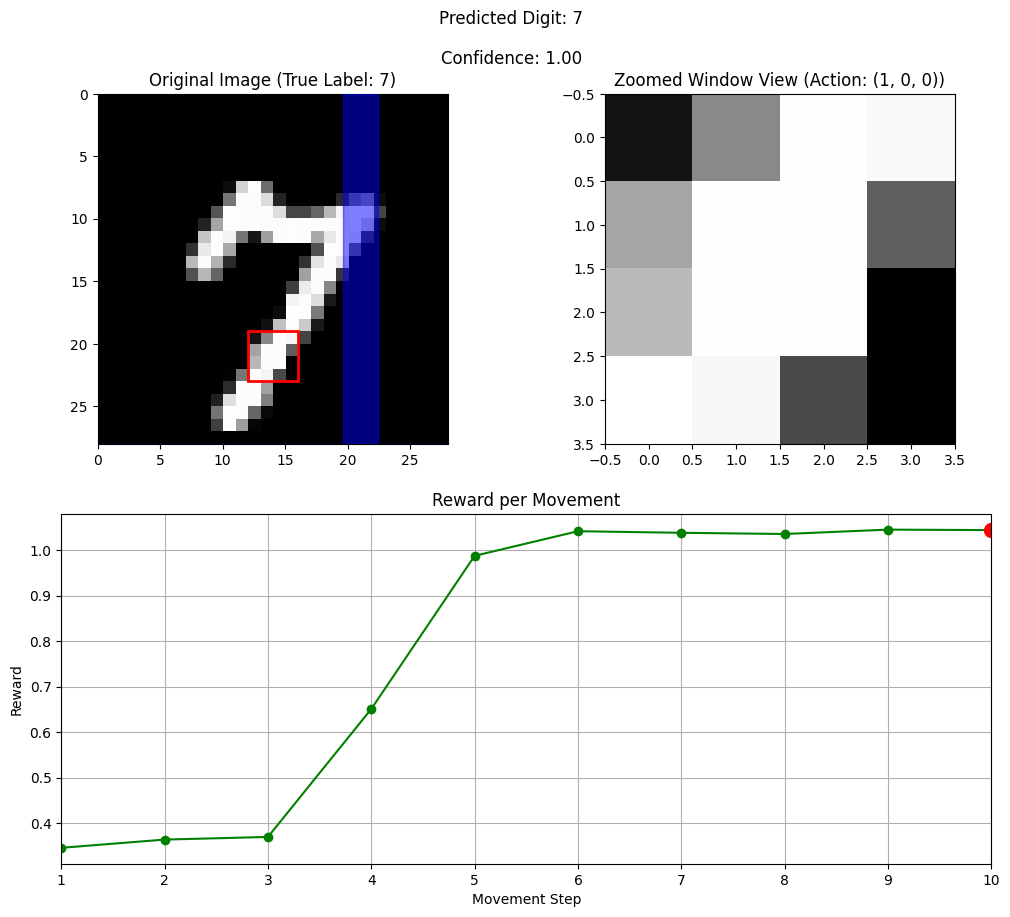

Selected test image index: 994


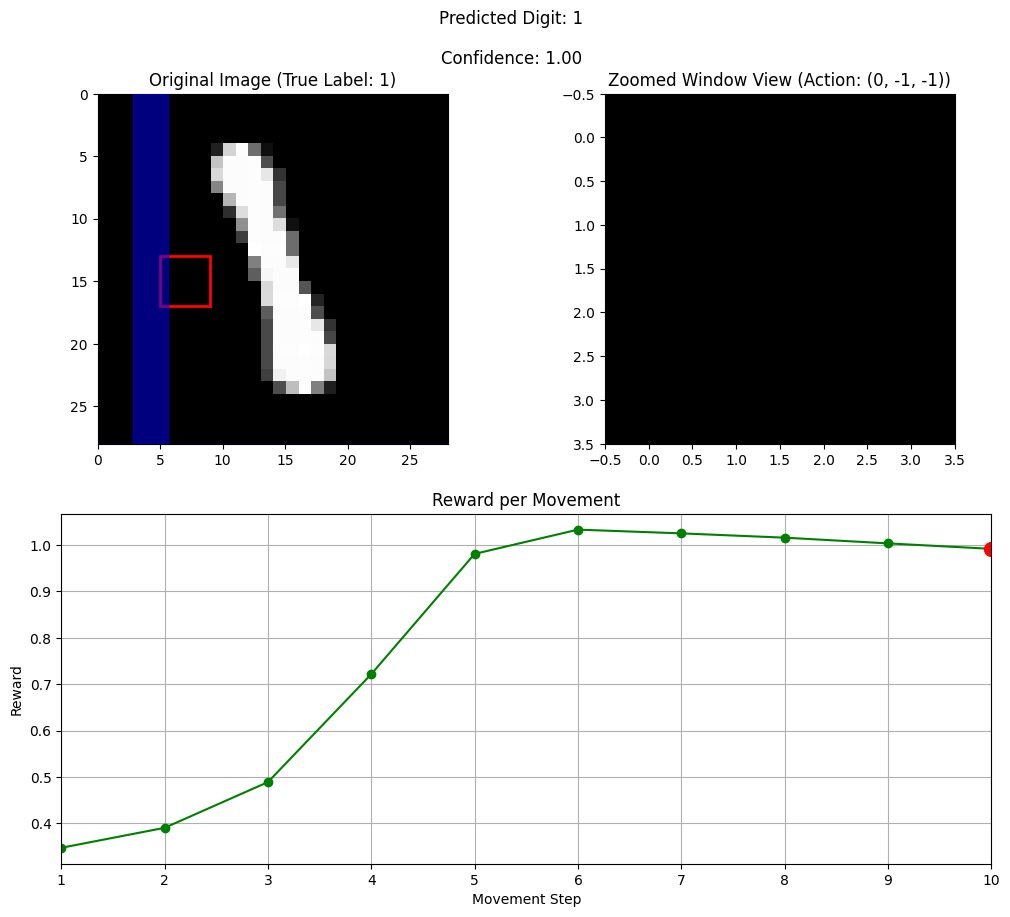

Selected test image index: 9340


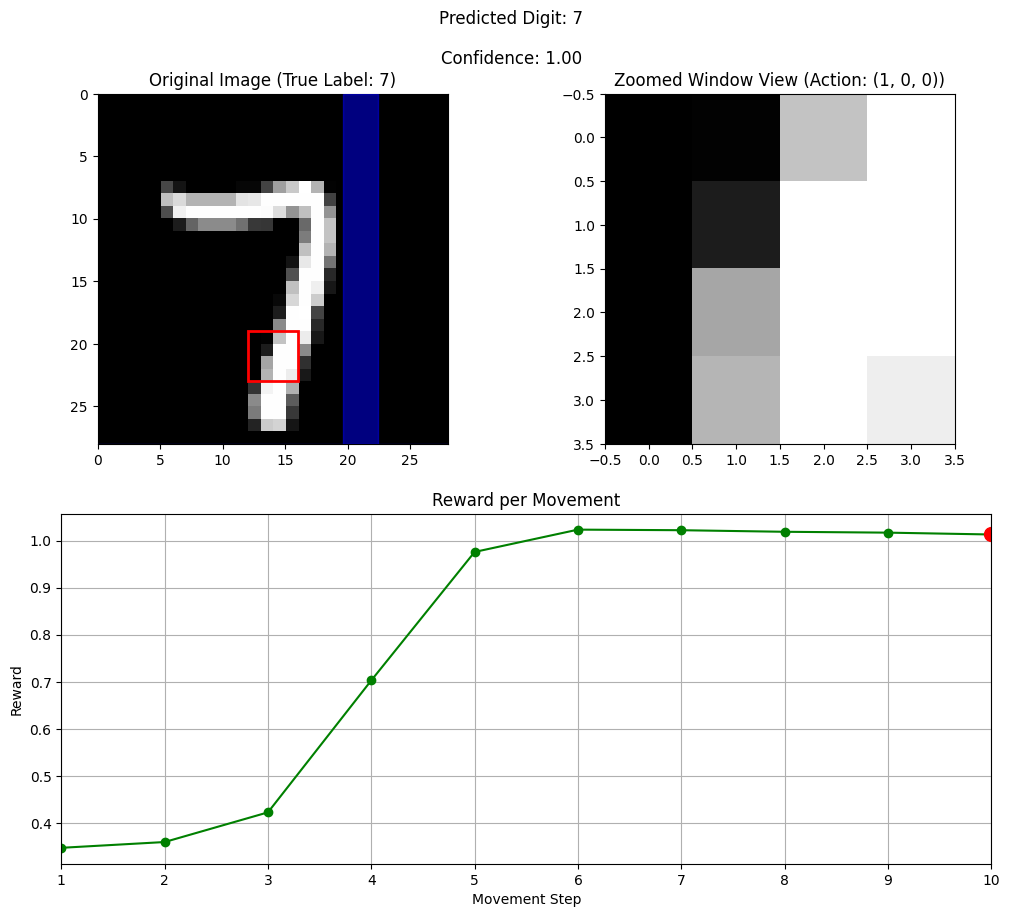

Selected test image index: 3404


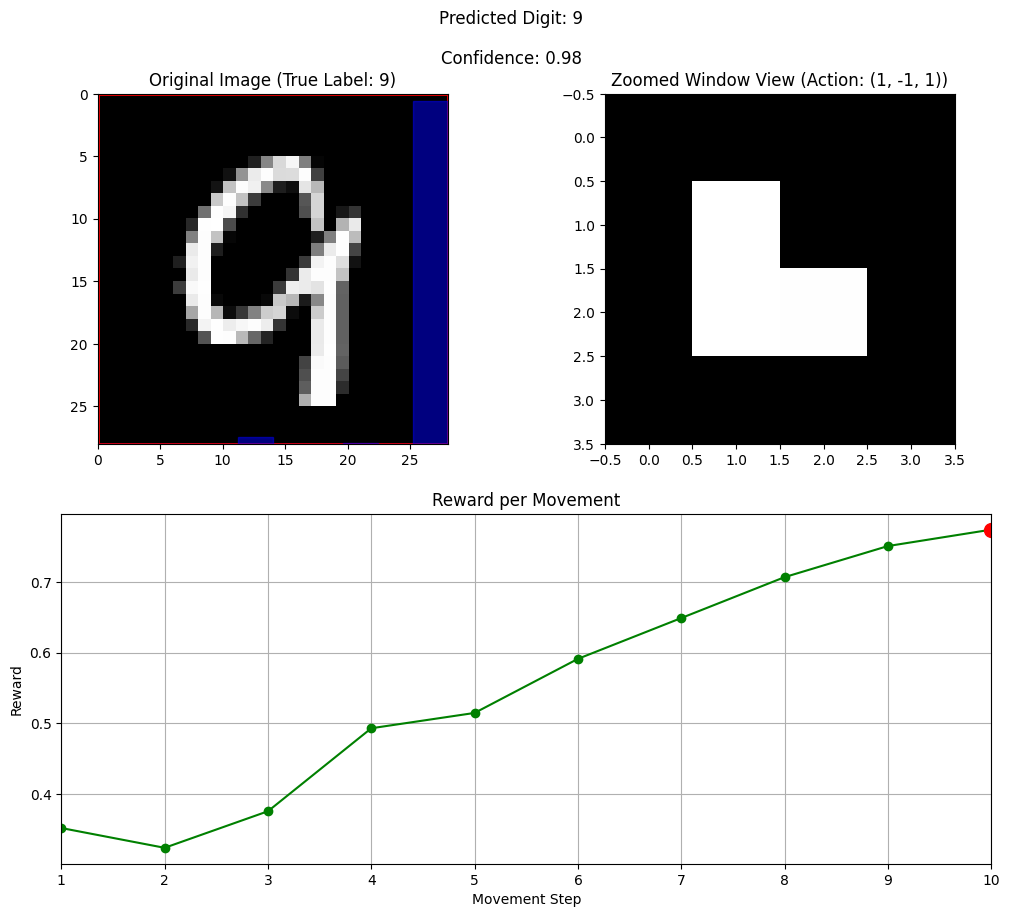

Selected test image index: 2827


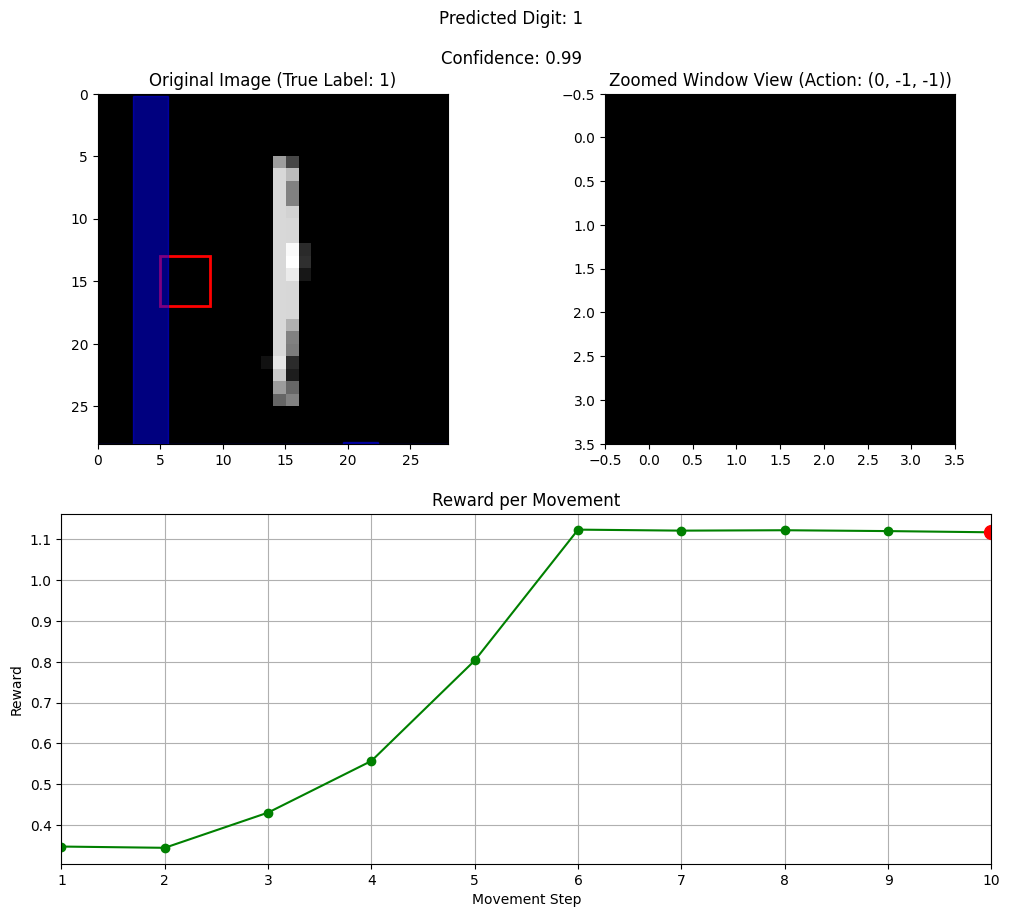

Selected test image index: 9697


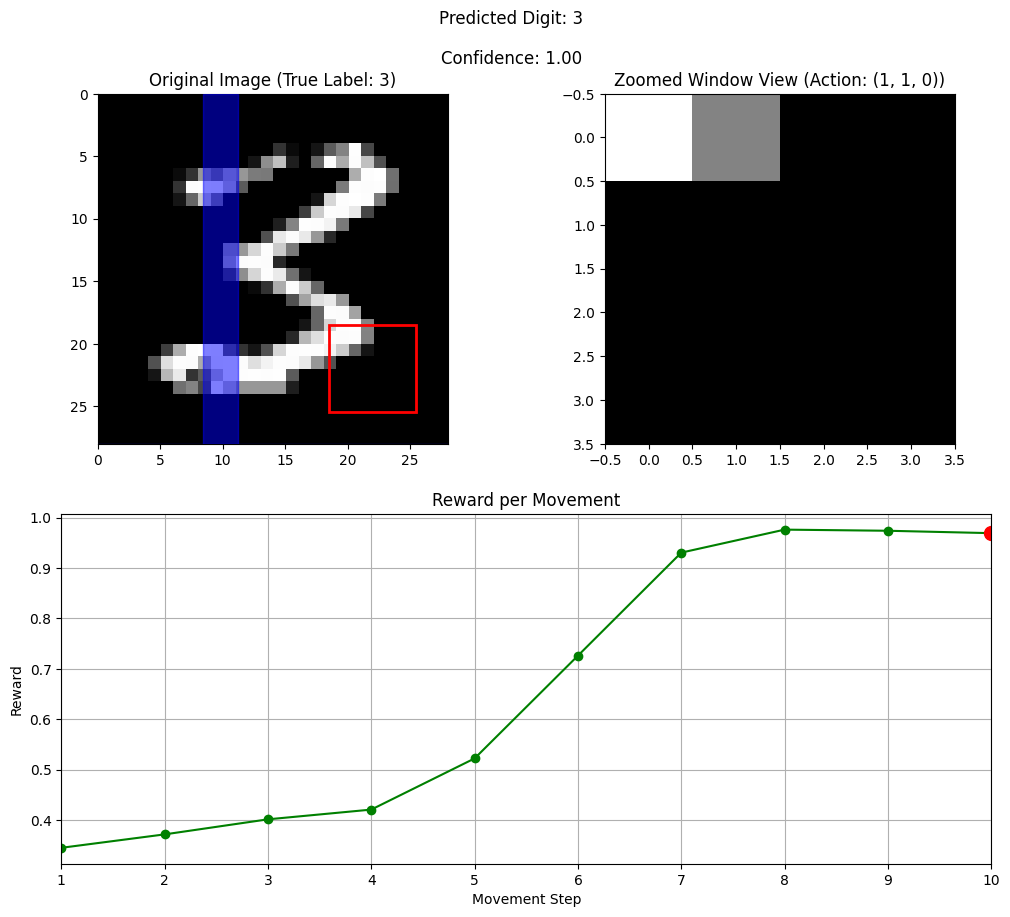

Selected test image index: 9131


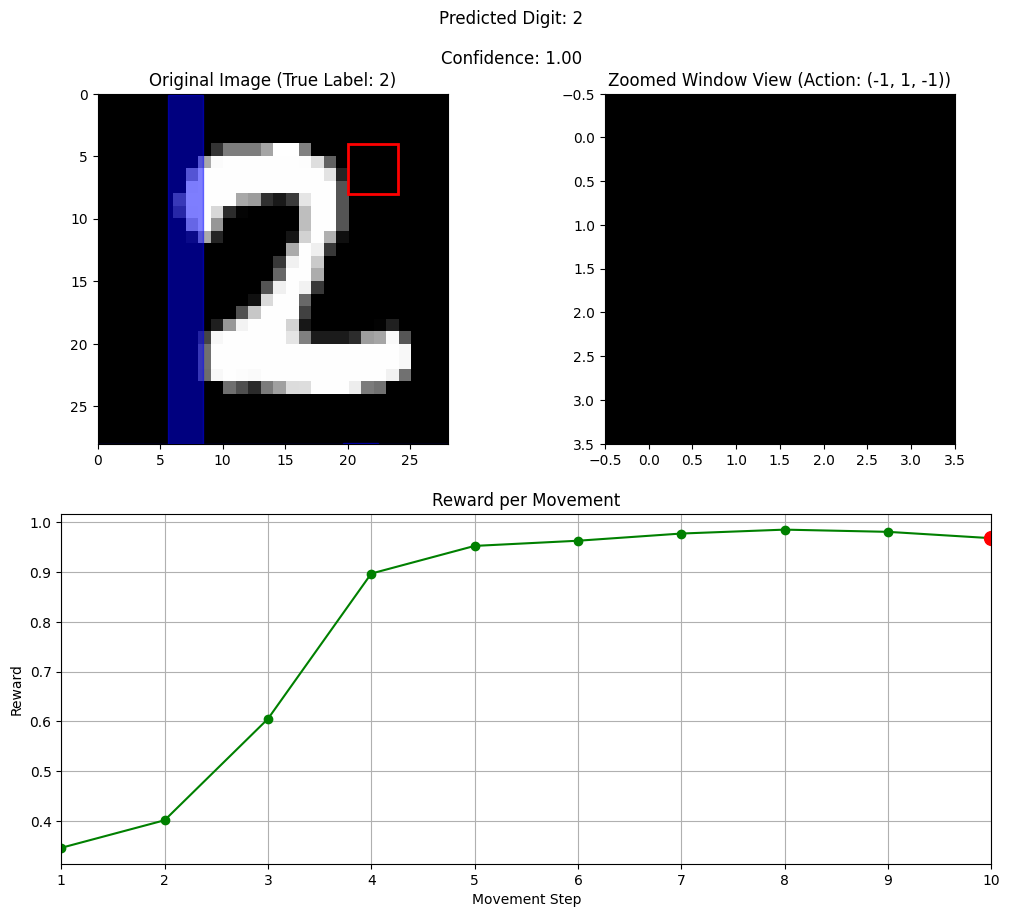

Selected test image index: 7076


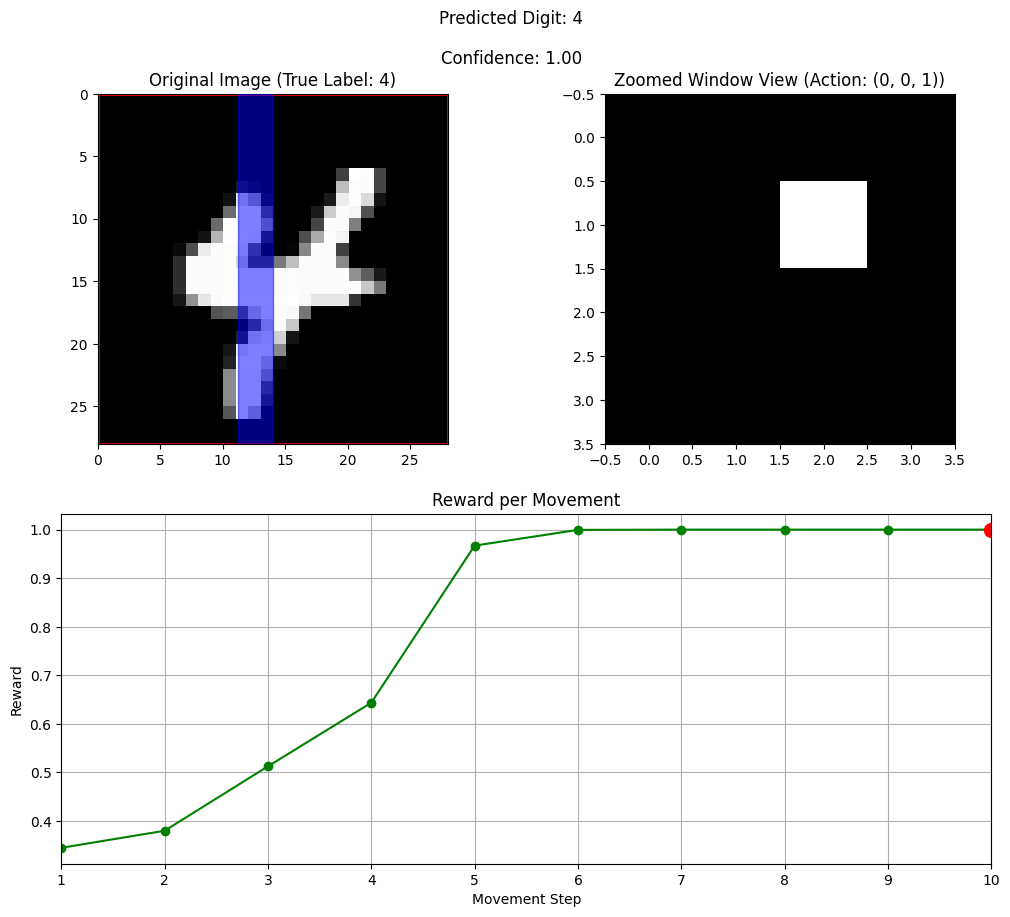

Selected test image index: 2325


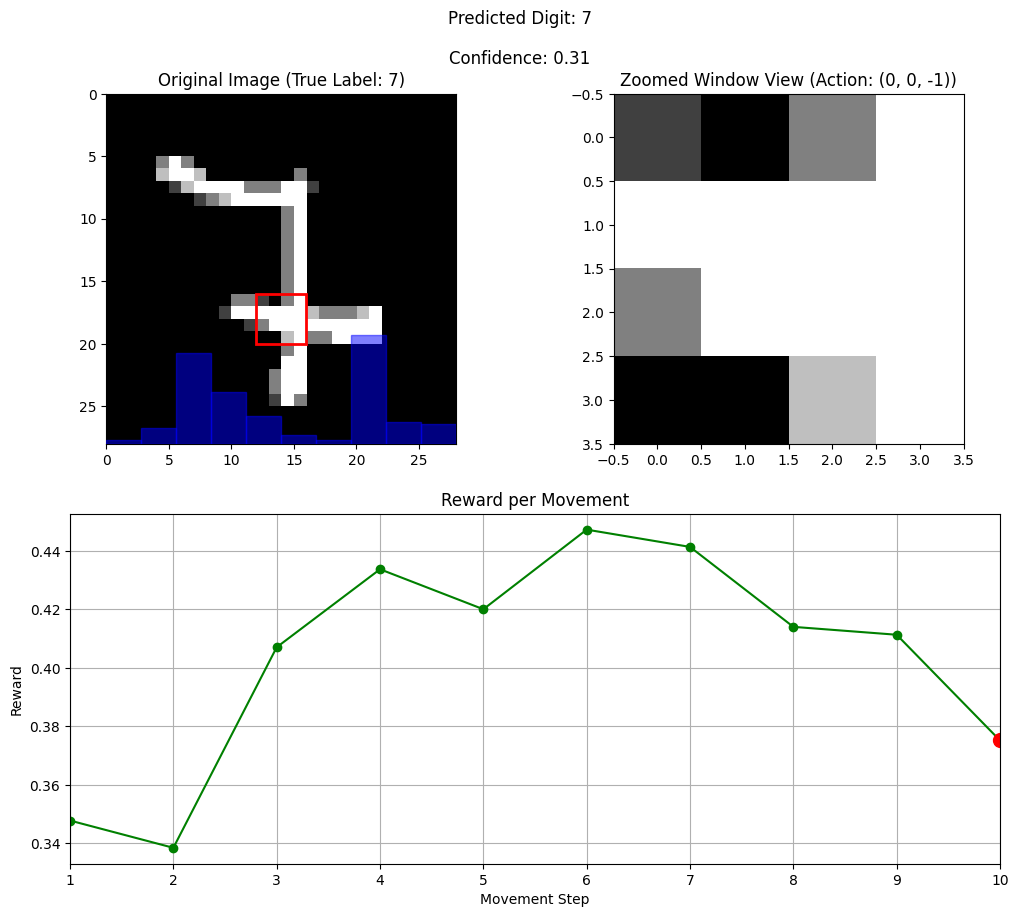

Selected test image index: 1300


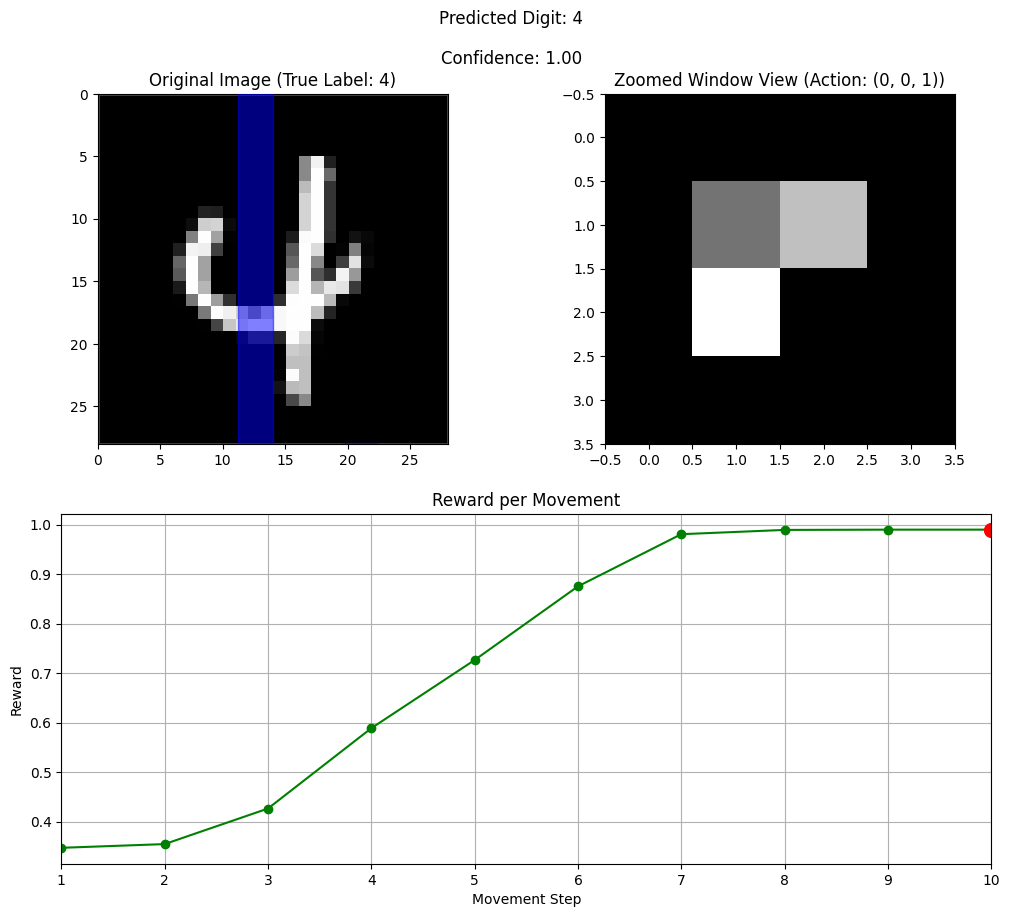

Selected test image index: 7699


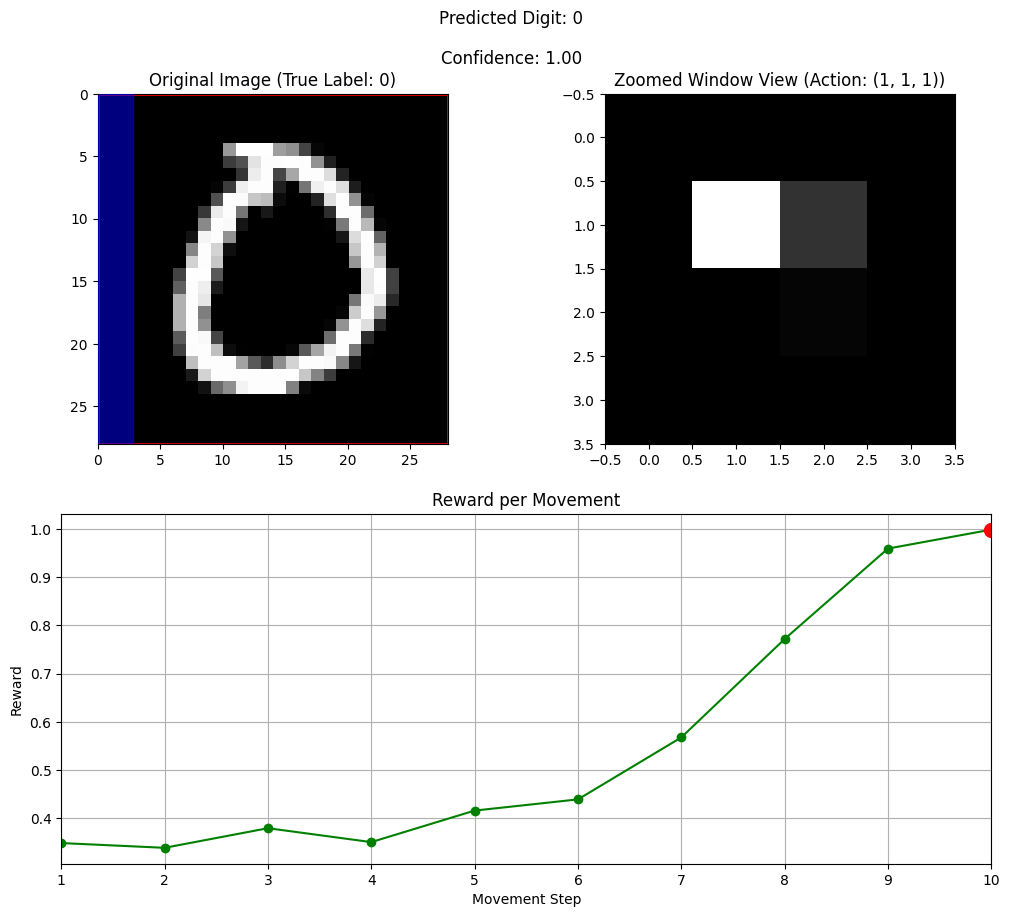

Selected test image index: 2049


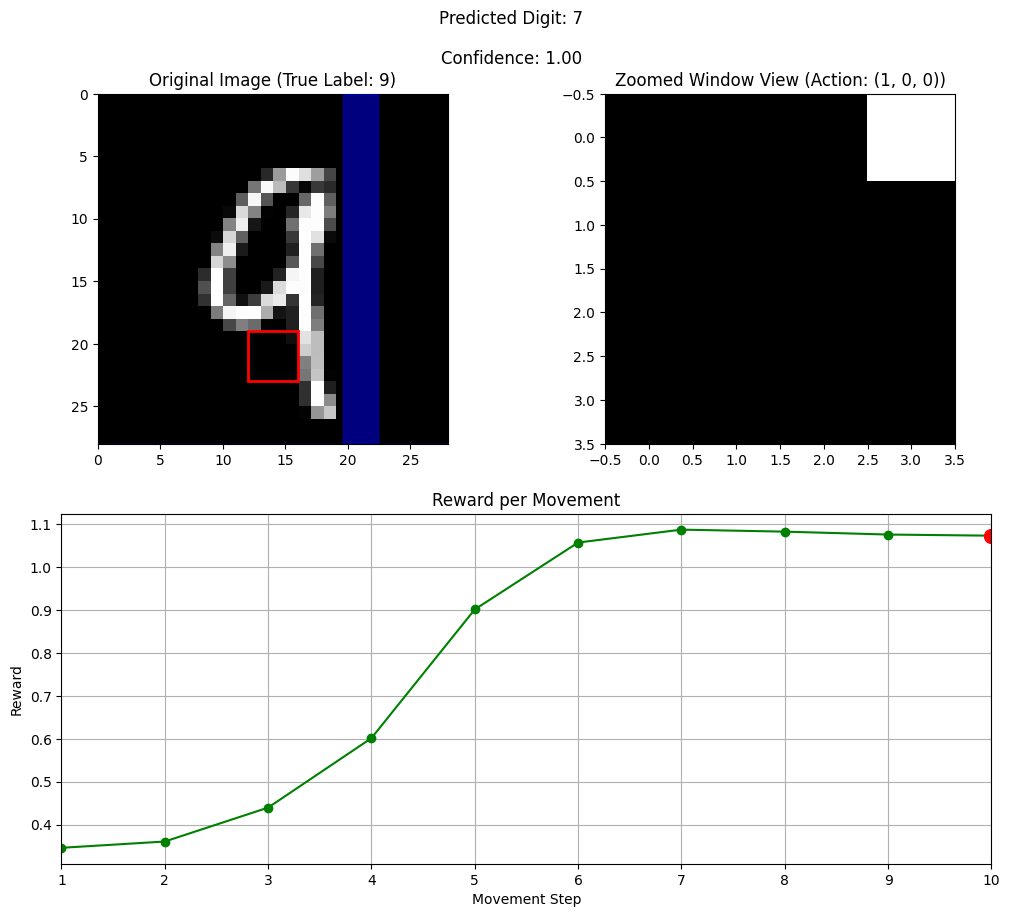

Selected test image index: 6536


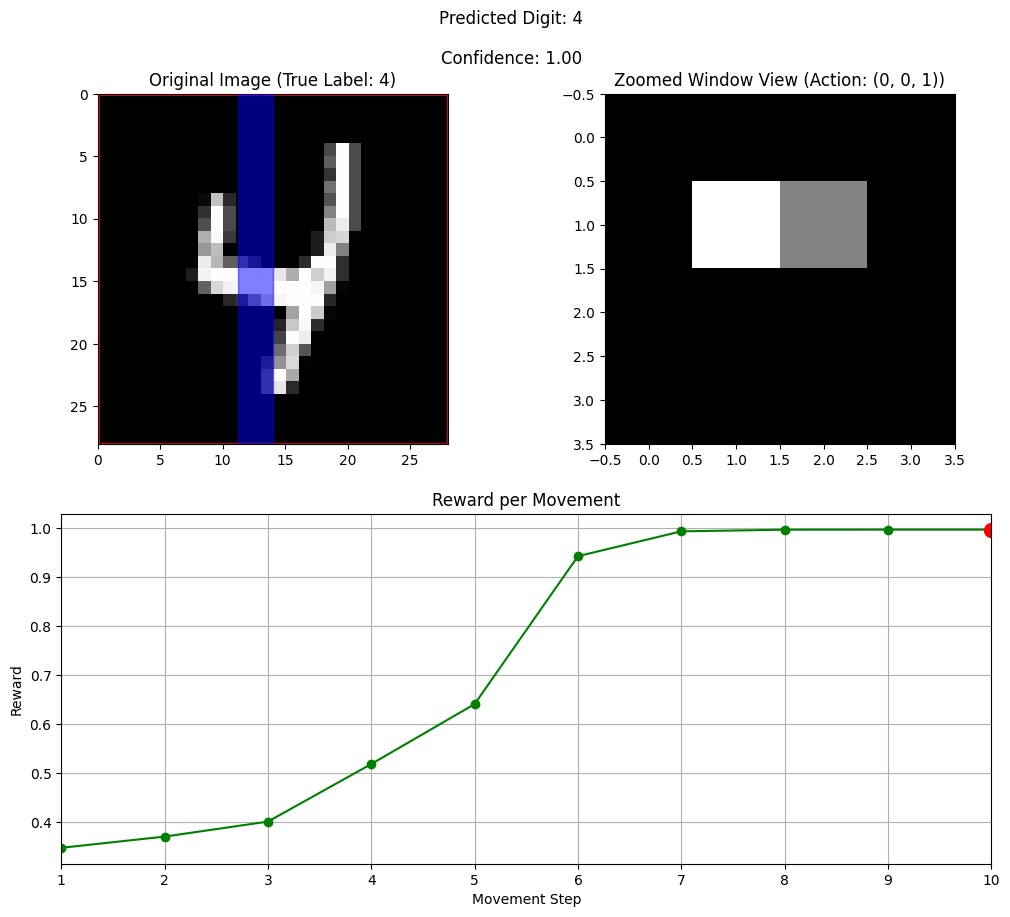

Selected test image index: 9316


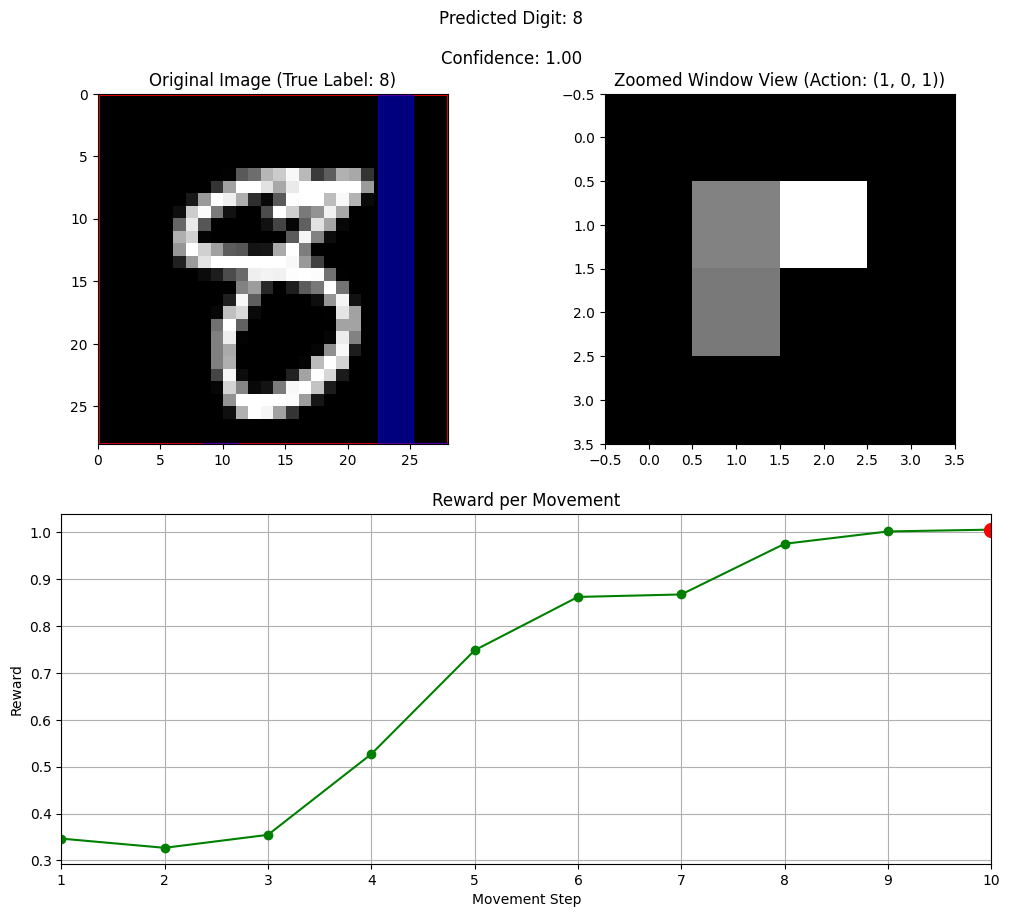

Selected test image index: 3606


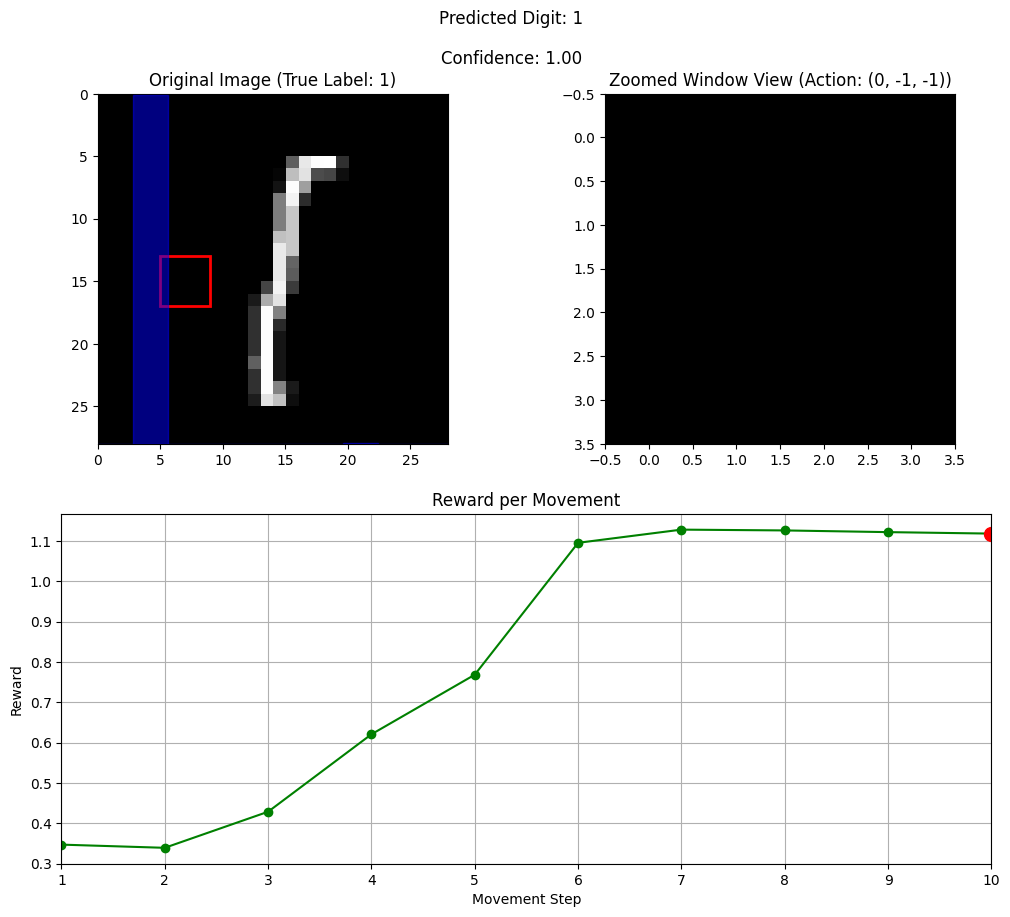

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torchvision import datasets, transforms
from matplotlib.animation import FFMpegWriter
import torch
import torch.nn.functional as F
import random

# Assume CONFIG, Environment, DTAgent, and DecisionTransformer are defined and imported.

def run_episode_eval(env, agent, state_size,
                     seq_length=CONFIG["seq_length"],
                     epsilon_const=CONFIG["epsilon_const"],
                     episode_id=100):
    """
    Runs one evaluation episode and records states, actions, prediction probabilities, and rewards.
    Returns a dictionary with episode data.
    """
    state = env.reset()
    image_id = env.current_index  # record image index
    # For the first token, use zeros for movement (3) and reward (1)
    init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
    tokens = [init_token]
    states_record = [state.tolist()]
    actions_record = []
    prediction_probs_record = []
    rewards_record = []  # record predicted reward per movement
    label = env.image_label
    predicted_digit = None

    for t in range(seq_length):
        # Pad the token sequence to length=seq_length
        current_seq = tokens.copy()
        while len(current_seq) < seq_length:
            current_seq.append(current_seq[-1])
        token_seq_tensor = torch.tensor(np.array(current_seq), dtype=torch.float32)\
                              .unsqueeze(0).to(agent.device)
        action, predicted_digit, digit_logits, action_index, predicted_reward = agent.select_action(token_seq_tensor)
        new_state, done, gt_label = env.step(action)

        # Get prediction probabilities from the digit head
        digit_probs = F.softmax(digit_logits, dim=-1).cpu().detach().numpy().tolist()

        states_record.append(new_state.tolist())
        actions_record.append(action)
        prediction_probs_record.append(digit_probs)
        rewards_record.append(predicted_reward)  # record the reward for this movement

        # Create new token: new_state + action (3 values) + predicted reward (1 value)
        movement_array = np.array(action, dtype=np.float32)
        reward_array = np.array([predicted_reward], dtype=np.float32)
        new_token = np.concatenate([new_state, movement_array, reward_array])
        tokens.append(new_token)

        if done:
            break

    # Ensure records have exactly seq_length entries where needed
    while len(states_record) < seq_length + 1:
        states_record.append(states_record[-1])
    while len(actions_record) < seq_length:
        actions_record.append(actions_record[-1])
    while len(prediction_probs_record) < seq_length:
        prediction_probs_record.append(prediction_probs_record[-1])
    while len(rewards_record) < seq_length:
        rewards_record.append(rewards_record[-1])

    episode_data = {
        'predicted_digit': predicted_digit,
        'true_label': label,
        'states': states_record,           # length: seq_length+1 (initial state + steps)
        'actions': actions_record,         # length: seq_length
        'prediction_probs': prediction_probs_record,  # length: seq_length
        'rewards': rewards_record,         # list of rewards per movement
        'image_id': image_id,
        'episode': episode_id
    }
    return episode_data

def visualize_episode(episode_data, test_images):
    """
    Visualizes a single episode.
    Expects episode_data to have keys: 'image_id', 'states', 'actions', 'true_label',
    'prediction_probs', 'rewards', 'predicted_digit', and 'episode'.
    """
    image_id = episode_data['image_id']
    states = episode_data['states']
    actions = episode_data['actions']
    true_label = episode_data['true_label']
    prediction_probs = episode_data['prediction_probs']
    rewards = episode_data['rewards']
    predicted_digit = episode_data['predicted_digit']

    # Final confidence is the maximum probability from the last time step.
    final_confidence = max(prediction_probs[-1])
    image = test_images[image_id]  # Test images are assumed in the range [0,1]

    # Set up the figure with three subplots:
    # - ax1: Original image with an inset bar chart for digit probabilities.
    # - ax2: Zoomed window view.
    # - ax3: Reward per movement plot.
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    base_size = CONFIG["BASE_IMAGE_SIZE"]
    ax1.imshow(image, cmap='gray', extent=[0, base_size, base_size, 0])
    ax1.set_title(f"Original Image (True Label: {true_label})")

    # Create an inset axis on ax1 for the probability bar chart.
    prob_ax = ax1.inset_axes([0, 0, 1, 1])
    prob_ax.set_xlim(0, 10)
    prob_ax.set_ylim(0, 1)
    prob_ax.axis('off')

    # Calculate bar width so that 10 bars fit in the image width.
    bar_width = 1
    bar_container = prob_ax.bar(
        np.arange(10) * bar_width + bar_width/2,
        np.zeros(10),
        width=bar_width,
        align='center',
        alpha=0.5
    )

    ax2.set_title("Zoomed Window View")
    ax3.set_title("Reward per Movement")
    ax3.set_xlabel("Movement Step")
    ax3.set_ylabel("Reward")

    # Display final predicted digit and confidence at the top of the figure.
    fig.text(0.5, 0.95, f'Predicted Digit: {predicted_digit}', ha='center', fontsize=12)
    fig.text(0.5, 0.91, f'Confidence: {final_confidence:.2f}', ha='center', fontsize=12)

    def animate(i):
        # Update the zoomed view subplot and rectangle on original image.
        state = np.array(states[i+1])
        action = actions[i]
        # Assuming that the zoom level is stored at index 16 (after the 4x4 window view)
        zoom_level = state[16] if len(state) > 16 else 1  # fallback in case of different state size
        probs = prediction_probs[i]

        # Update zoomed view (first 16 values form a 4x4 window view)
        ax2.cla()
        window_view = state[:16].reshape((4, 4))
        ax2.imshow(window_view, cmap='gray', interpolation='nearest')
        ax2.set_title(f"Zoomed Window View (Action: {action})")

        # Remove previous rectangle annotations from ax1.
        for patch in reversed(ax1.patches):
            patch.remove()

        # Draw rectangle on the original image to indicate the zoom window.
        rect_width = rect_height = 4 * zoom_level
        center = base_size // 2
        # Last two values in state vector indicate window offset (from center)
        x_offset = state[-2]
        y_offset = state[-1]
        x_pos = center + x_offset - rect_width / 2
        y_pos = center + y_offset - rect_height / 2
        rect = plt.Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        # Update the probability bars in the inset axis.
        for bar, height in zip(bar_container, probs):
            bar.set_height(height)
            bar.set_color('blue')

        # Update reward per movement plot:
        ax3.cla()
        steps = np.arange(1, len(rewards) + 1)
        ax3.plot(steps, rewards, marker='o', color='green')
        ax3.set_title("Reward per Movement")
        ax3.set_xlabel("Movement Step")
        ax3.set_ylabel("Reward")
        ax3.set_xlim(1, len(rewards))
        # Highlight the current step's reward
        current_reward = rewards[i]
        ax3.plot(i+1, current_reward, marker='o', markersize=10, color='red')
        ax3.grid(True)
        return []

    ani = animation.FuncAnimation(fig, animate, frames=len(actions), interval=500, blit=False, repeat=False)
    writer = FFMpegWriter(fps=2, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f"episode_{episode_data['episode']}_visualization.mp4", writer=writer)
    plt.show()

def main():
    # Load MNIST test dataset using CONFIG values.
    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images_all = test_dataset.data.numpy().astype(np.float32) / 255.0
    labels_all = test_dataset.targets.numpy()

    # Prepare the DTAgent.
    # Create a dummy environment to get the state size.
    dummy_image = test_images_all[0:1]
    dummy_label = labels_all[0:1]
    dummy_env = Environment(dummy_image, dummy_label, mode="test")
    state_size = dummy_env.get_state().shape[0]

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy for evaluation

    # Set number of examples.
    n_examples = 20
    indices = random.sample(range(len(test_dataset)), n_examples)

    for episode_id, random_idx in enumerate(indices):
        print(f"Selected test image index: {random_idx}")
        # Get the test image and label as a slice (so that shape is consistent with Environment expectations).
        test_image = test_images_all[random_idx:random_idx+1]
        test_label = labels_all[random_idx:random_idx+1]

        # Create a test environment with just this image in test mode.
        test_env = Environment(test_image, test_label, mode="test")
        seq_length = CONFIG["seq_length"]

        # Run one evaluation episode.
        episode_data = run_episode_eval(test_env, agent, state_size, seq_length=seq_length, episode_id=episode_id)

        # Visualize the episode.
        visualize_episode(episode_data, test_image)

if __name__ == "__main__":
    main()


Evaluated 10000 test images.
Accuracy: 0.8666 (86.66%)


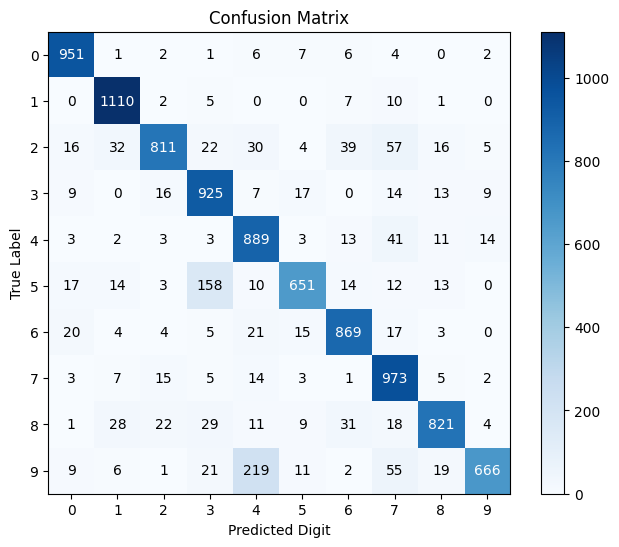

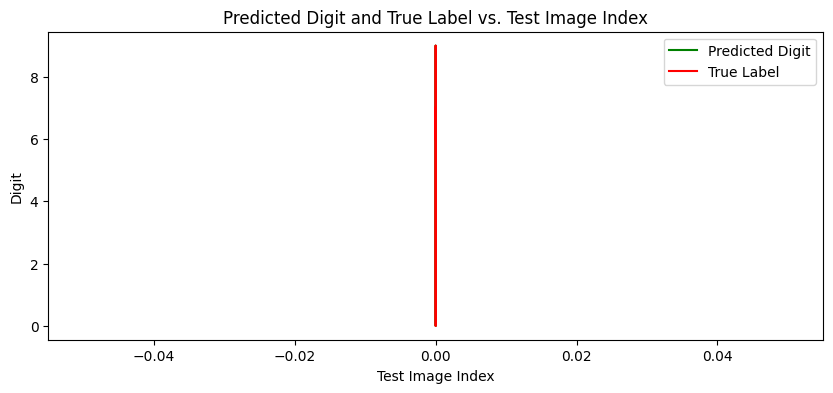

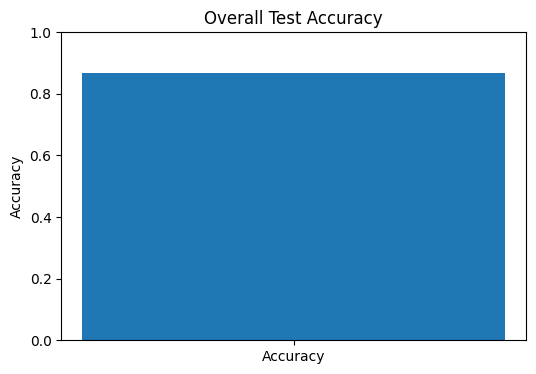

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------------------------
# Evaluation and Data Collection Function
# ---------------------------
def evaluate_test_set(batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load MNIST test dataset using CONFIG variables.
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images = test_dataset.data.numpy().astype(np.float32) / 255.0
    test_labels = test_dataset.targets.numpy()

    # Create a list of environments—one per test image.
    # In "test" mode, Environment.reset() uses deterministic sampling.
    test_envs = []
    for i in range(len(test_images)):
        env = Environment(test_images[i:i+1], test_labels[i:i+1], mode="test")
        test_envs.append(env)

    state_size = test_envs[0].get_state().shape[0]
    seq_length = CONFIG["seq_length"]  # Use the same sequence length as in training.

    # Initialize the DTAgent with the correct state size and load trained weights.
    agent = DTAgent(state_size=state_size, device=device)
    # Load weights from the provided training file path.
    agent.model.load_state_dict(torch.load("/content/dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy evaluation

    total = len(test_envs)
    correct = 0
    all_predicted = []
    all_labels = []
    all_image_ids = []

    # Process test environments in batches.
    for i in range(0, total, batch_size):
        batch_envs = test_envs[i:i+batch_size]
        predicted_digits, labels, image_ids = run_batch_episode_eval(batch_envs, agent, state_size, seq_length=seq_length)
        for pred, label, img_id in zip(predicted_digits, labels, image_ids):
            all_predicted.append(pred)
            all_labels.append(label)
            all_image_ids.append(img_id)
            if pred == label:
                correct += 1

    accuracy = correct / total
    print(f"Evaluated {total} test images.")
    print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
    return all_image_ids, all_predicted, all_labels, accuracy

# ---------------------------
# Run Evaluation
# ---------------------------
image_ids, predicted_digits, true_labels, accuracy = evaluate_test_set(batch_size=64)

# ---------------------------
# Visualization 1: Confusion Matrix
# ---------------------------
conf_matrix = confusion_matrix(true_labels, predicted_digits, labels=list(range(10)))

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Predicted Digit')
plt.ylabel('True Label')

# Add numbers inside the cells.
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")
plt.show()

# ---------------------------
# Visualization 2: Predicted vs. True Digits Across Test Images
# ---------------------------
plt.figure(figsize=(10, 4))
plt.plot(image_ids, predicted_digits, 'g-', label='Predicted Digit', drawstyle='steps-post')
plt.plot(image_ids, true_labels, 'r-', label='True Label', drawstyle='steps-post')
plt.xlabel('Test Image Index')
plt.ylabel('Digit')
plt.title('Predicted Digit and True Label vs. Test Image Index')
plt.legend()
plt.show()

# ---------------------------
# Visualization 3: Overall Accuracy
# ---------------------------
plt.figure(figsize=(6, 4))
plt.bar(["Accuracy"], [accuracy])
plt.ylim(0, 1)
plt.title("Overall Test Accuracy")
plt.ylabel("Accuracy")
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


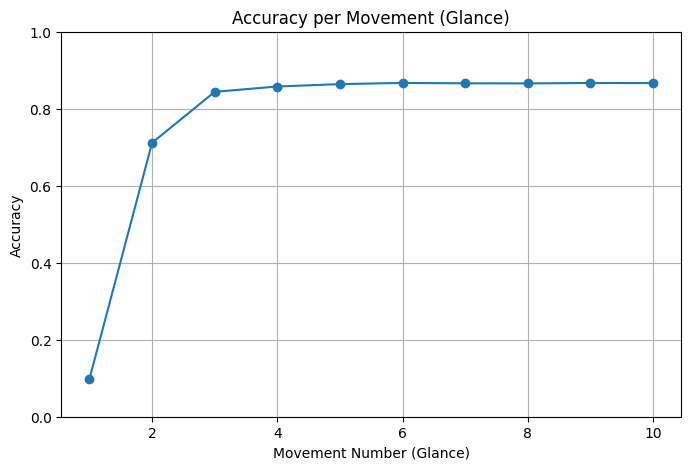

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ---------------------------
# Batch Evaluation Function (Recording Predictions per Movement)
# ---------------------------
def run_batch_episode_eval_with_all_predictions(envs, agent, state_size,
                                                  seq_length=CONFIG["seq_length"],
                                                  epsilon_const=CONFIG["epsilon_const"]):
    """
    Run evaluation episodes in parallel while recording the predicted digit
    at each movement (glance). Returns a list (length=batch_size) where each
    element is a list of predicted digits at each time step.
    """
    batch_size = len(envs)
    tokens_batch = []
    labels_batch = []
    image_ids_batch = []
    # For storing predictions at each step for each episode.
    predictions_per_episode = [[] for _ in range(batch_size)]

    for env in envs:
        state = env.reset()  # In test mode, reset returns the test image state.
        # Initial token: state concatenated with zeros for movement (3) and reward (1).
        init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
        tokens_batch.append([init_token])
        labels_batch.append(env.image_label)
        image_ids_batch.append(env.current_index)

    # Run for exactly seq_length steps.
    for t in range(seq_length):
        current_batch = []
        # Prepare a padded sequence for each environment.
        for tokens in tokens_batch:
            if len(tokens) < seq_length:
                padded_tokens = tokens + [tokens[-1]] * (seq_length - len(tokens))
            else:
                padded_tokens = tokens[-seq_length:]
            current_batch.append(padded_tokens)

        token_seq_batch = torch.tensor(np.array(current_batch), dtype=torch.float32).to(agent.device)

        agent.model.eval()
        with torch.no_grad():
            digit_logits, movement_q = agent.model(token_seq_batch)

        # Use outputs at the last time step.
        last_movement_q = movement_q[:, -1, :]  # shape: (batch, num_actions)
        last_digit_logits = digit_logits[:, -1, :]  # shape: (batch, num_digit_classes)

        actions = []
        for i in range(batch_size):
            # Greedy policy: choose the action with highest Q-value.
            action_index = torch.argmax(last_movement_q[i]).item()
            action = agent.action_space[action_index]
            actions.append(action)
            # Predicted digit for this movement.
            predicted_digit = torch.argmax(torch.softmax(last_digit_logits[i], dim=-1)).item()
            predictions_per_episode[i].append(predicted_digit)

        # Update each environment.
        for i, env in enumerate(envs):
            new_state, done, _ = env.step(actions[i])
            # Use the Q-value of the chosen action as a proxy reward.
            predicted_reward = last_movement_q[i, torch.argmax(last_movement_q[i]).item()].item()
            movement_array = np.array(actions[i], dtype=np.float32)
            reward_array = np.array([predicted_reward], dtype=np.float32)
            new_token = np.concatenate([new_state, movement_array, reward_array])
            tokens_batch[i].append(new_token)

    return predictions_per_episode, labels_batch, image_ids_batch

# ---------------------------
# Evaluation Function for Accuracy per Movement
# ---------------------------
def evaluate_accuracy_per_movement(batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load MNIST test dataset.
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images = test_dataset.data.numpy().astype(np.float32) / 255.0
    test_labels = test_dataset.targets.numpy()

    # Create an environment per test image.
    test_envs = []
    for i in range(len(test_images)):
        env = Environment(test_images[i:i+1], test_labels[i:i+1], mode="test")
        test_envs.append(env)

    state_size = test_envs[0].get_state().shape[0]
    seq_length = CONFIG["seq_length"]

    # Initialize the agent and load trained weights.
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("/content/dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy evaluation

    total = len(test_envs)
    all_predictions = []  # List of lists (one per episode)
    all_labels = []       # True labels for each episode

    # Process the test environments in batches.
    for i in range(0, total, batch_size):
        batch_envs = test_envs[i:i+batch_size]
        predictions_batch, labels_batch, _ = run_batch_episode_eval_with_all_predictions(
            batch_envs, agent, state_size, seq_length=seq_length
        )
        all_predictions.extend(predictions_batch)
        all_labels.extend(labels_batch)

    # Compute accuracy per movement.
    accuracies = []
    # For each movement (from 0 to seq_length-1):
    for t in range(seq_length):
        correct = 0
        total_count = 0
        for preds, label in zip(all_predictions, all_labels):
            # Compare the prediction at step t with the true label.
            if preds[t] == label:
                correct += 1
            total_count += 1
        accuracies.append(correct / total_count)
    return accuracies

# ---------------------------
# Generate and Plot the Chart
# ---------------------------
accuracies_per_movement = evaluate_accuracy_per_movement(batch_size=64)
movements = list(range(1, CONFIG["seq_length"] + 1))

plt.figure(figsize=(8, 5))
plt.plot(movements, accuracies_per_movement, marker='o', linestyle='-')
plt.xlabel('Movement Number (Glance)')
plt.ylabel('Accuracy')
plt.title('Accuracy per Movement (Glance)')
plt.ylim(0, 1)
plt.grid(True)
plt.show()


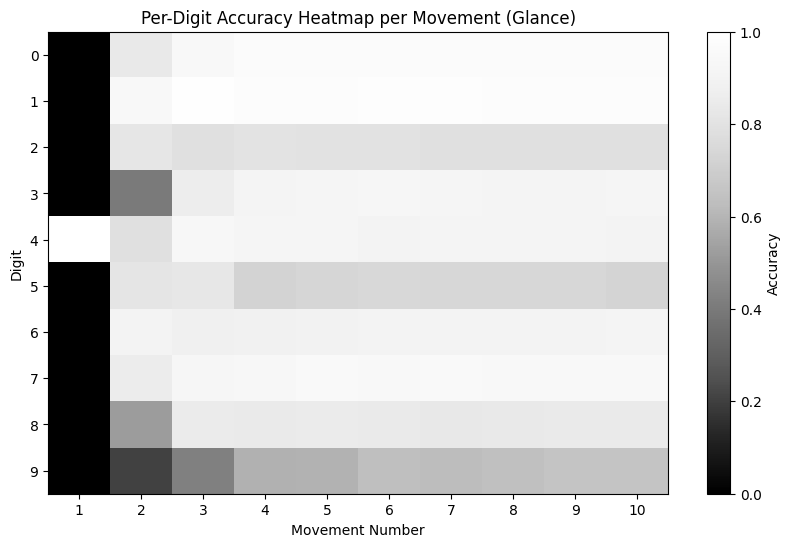

In [ ]:
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# ---------------------------
# Evaluation Function for Per-Digit, Per-Movement Accuracy
# ---------------------------
def evaluate_accuracy_matrix_per_movement(batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load MNIST test dataset.
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images = test_dataset.data.numpy().astype(np.float32) / 255.0
    test_labels = test_dataset.targets.numpy()

    # Create one environment per test image (in test mode).
    test_envs = []
    for i in range(len(test_images)):
        env = Environment(test_images[i:i+1], test_labels[i:i+1], mode="test")
        test_envs.append(env)

    state_size = test_envs[0].get_state().shape[0]
    seq_length = CONFIG["seq_length"]

    # Initialize the DTAgent and load trained weights.
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("/content/dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy evaluation

    all_predictions = []  # Will hold a list (for each test image) of prediction lists per movement.
    all_labels = []       # True labels for each test image.

    # Process test environments in batches.
    for i in range(0, len(test_envs), batch_size):
        batch_envs = test_envs[i:i+batch_size]
        predictions_batch, labels_batch, _ = run_batch_episode_eval_with_all_predictions(
            batch_envs, agent, state_size, seq_length=seq_length
        )
        all_predictions.extend(predictions_batch)
        all_labels.extend(labels_batch)

    # Initialize a matrix: rows represent digits (0-9), columns represent movement steps.
    accuracy_matrix = np.zeros((10, seq_length))
    counts = np.zeros(10)

    # For each test image, accumulate correct predictions per movement.
    for preds, true_label in zip(all_predictions, all_labels):
        counts[true_label] += 1
        for t in range(seq_length):
            if preds[t] == true_label:
                accuracy_matrix[true_label, t] += 1

    # Convert counts to accuracy values per digit per movement.
    for d in range(10):
        if counts[d] > 0:
            accuracy_matrix[d, :] /= counts[d]

    return accuracy_matrix

# ---------------------------
# Generate and Plot the Heatmap
# ---------------------------
accuracy_mat = evaluate_accuracy_matrix_per_movement(batch_size=64)
movements = np.arange(1, CONFIG["seq_length"] + 1)
digits = np.arange(10)

plt.figure(figsize=(10, 6))
# Using 'Greys_r' so that higher accuracies (closer to 1.0) appear darker.
plt.imshow(accuracy_mat, interpolation='nearest', cmap='Greys_r', aspect='auto')
plt.colorbar(label='Accuracy')
plt.xlabel('Movement Number')
plt.ylabel('Digit')
plt.xticks(np.arange(CONFIG["seq_length"]), labels=movements)
plt.yticks(np.arange(10), labels=digits)
plt.title('Per-Digit Accuracy Heatmap per Movement (Glance)')
plt.show()


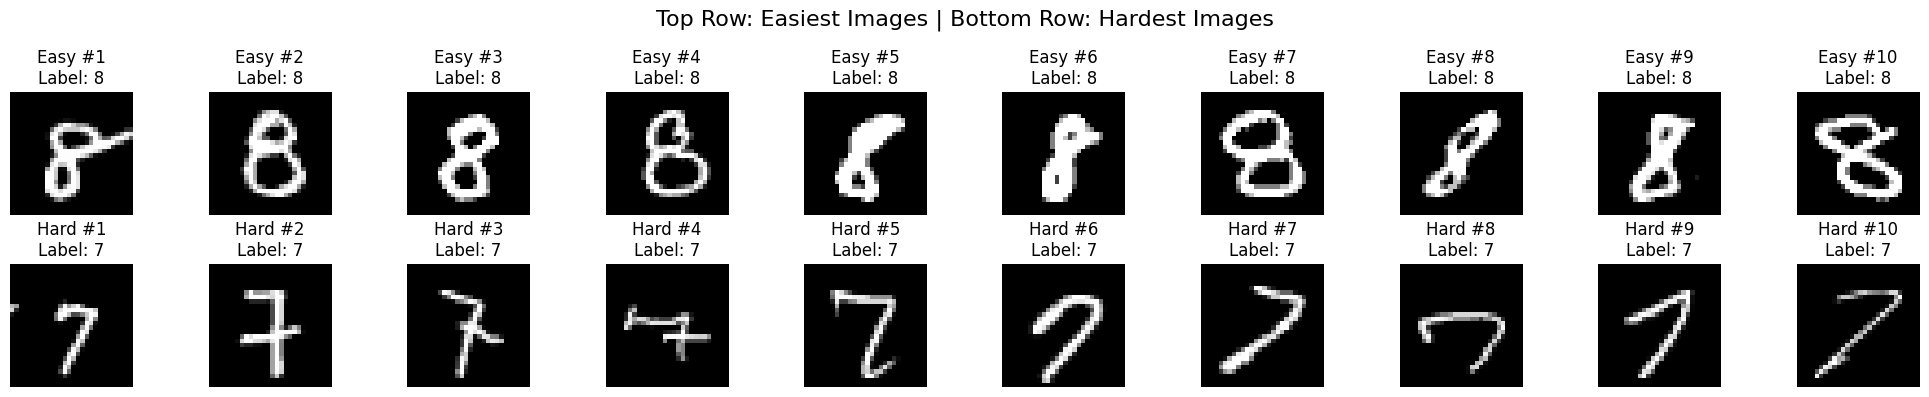

In [ ]:
import matplotlib.pyplot as plt

# Get the 10 easiest and 10 hardest image indices
easiest = ranked_indices[:10]
hardest = ranked_indices[-10:]

# Plot them side-by-side
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i, idx in enumerate(easiest):
    axs[0, i].imshow(train_images[idx], cmap='gray')
    axs[0, i].set_title(f"Easy #{i+1}\nLabel: {train_labels[idx]}")
    axs[0, i].axis('off')

for i, idx in enumerate(hardest[::-1]):
    axs[1, i].imshow(train_images[idx], cmap='gray')
    axs[1, i].set_title(f"Hard #{i+1}\nLabel: {train_labels[idx]}")
    axs[1, i].axis('off')

plt.suptitle("Top Row: Easiest Images | Bottom Row: Hardest Images", fontsize=16)
plt.tight_layout()
plt.show()


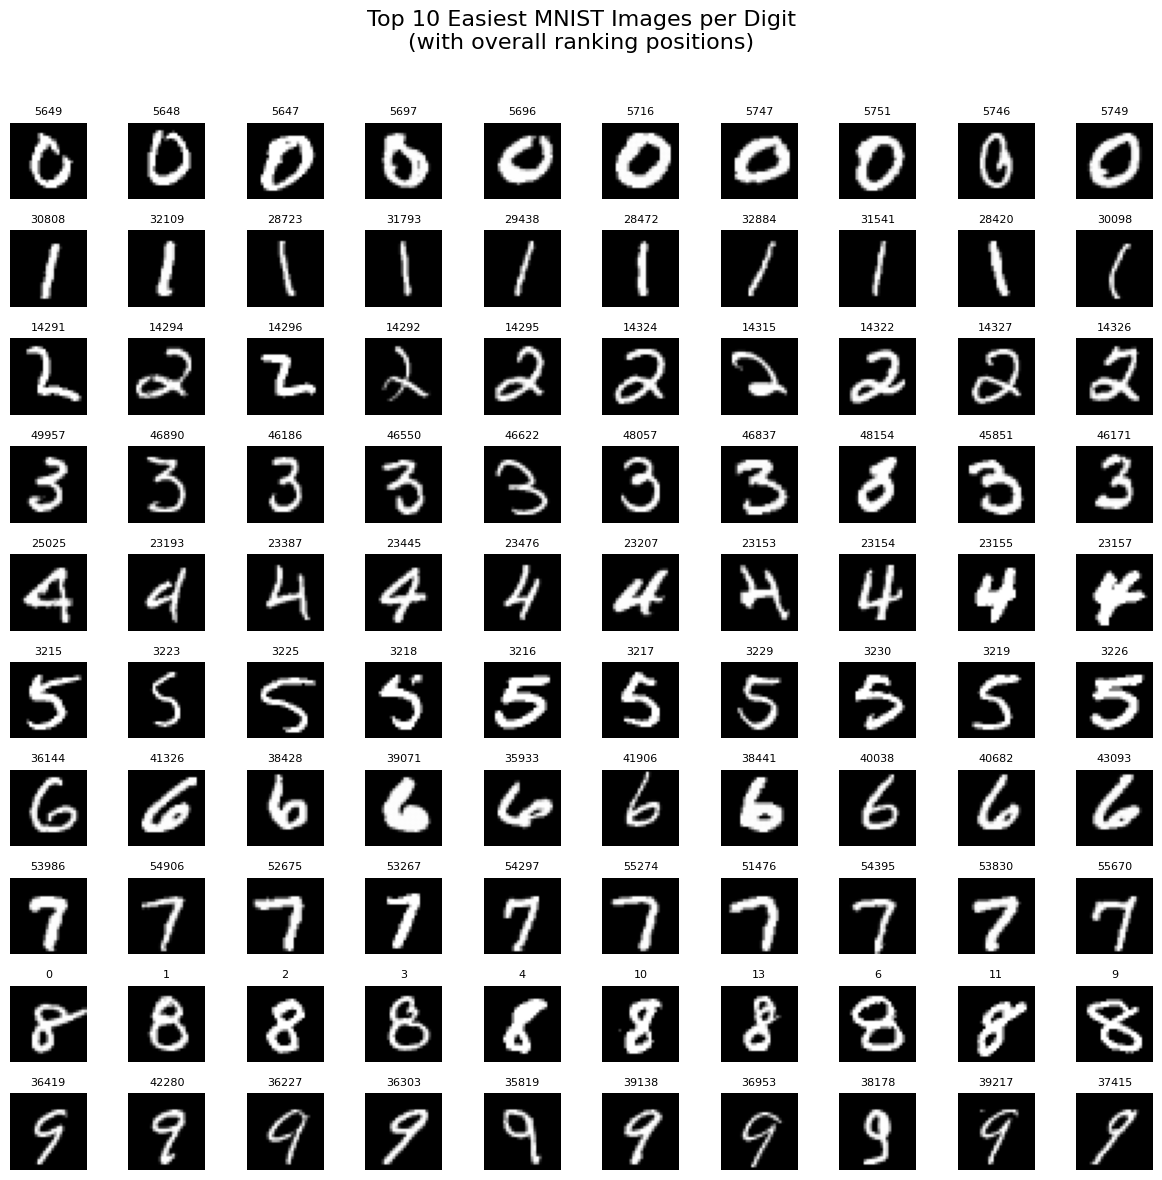

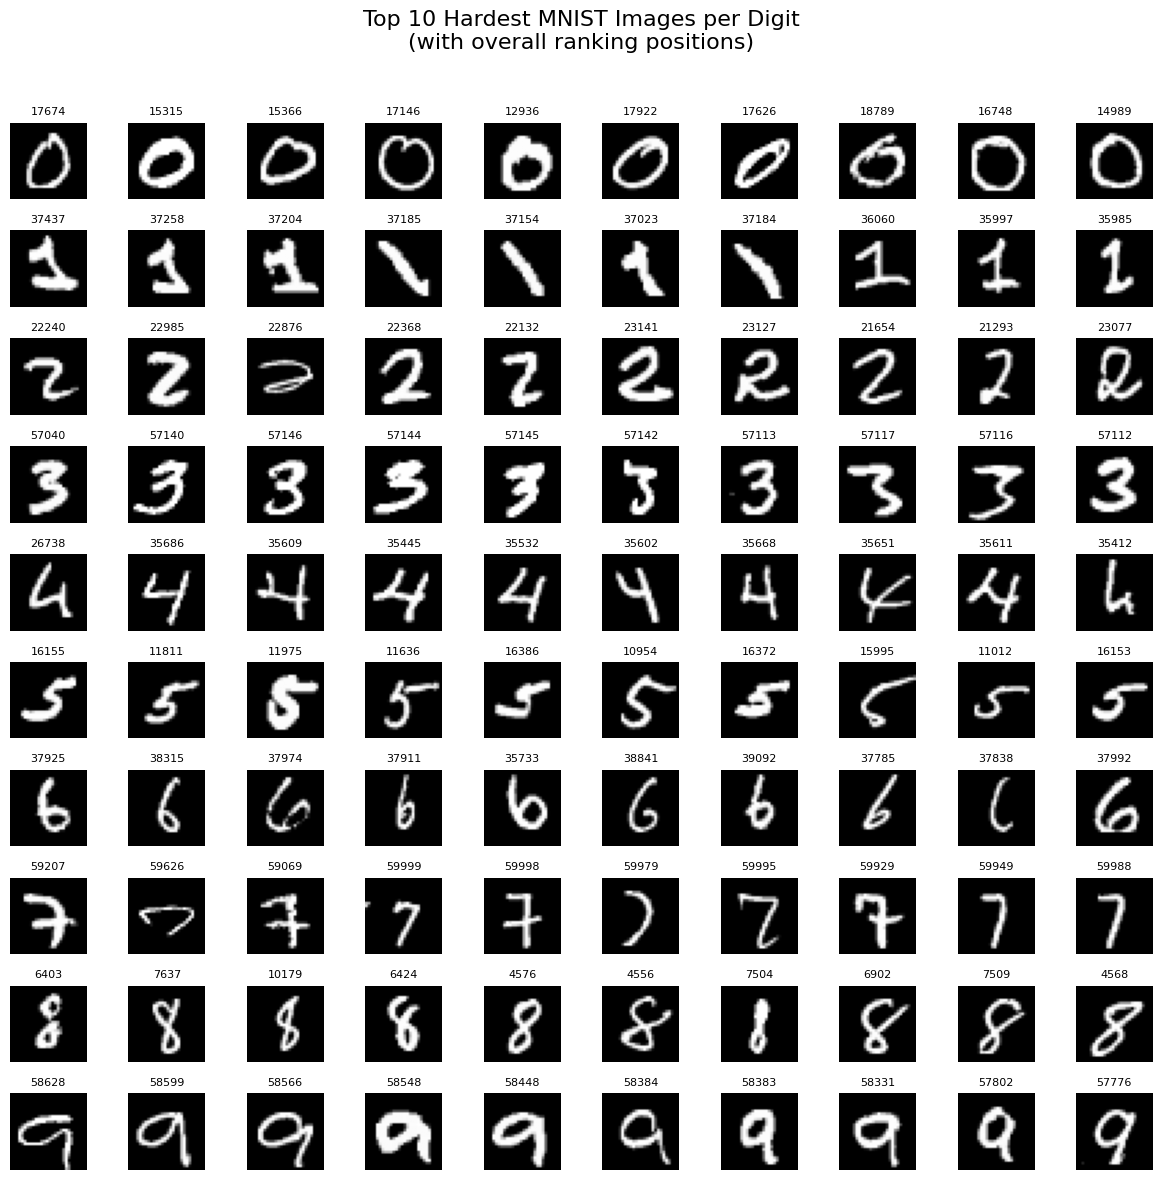

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_easiest_and_hardest(train_images, train_labels, image_difficulties, ranked_indices):
    # Prepare dictionaries to store indices and overall ranking positions for each digit.
    easiest_images = {}
    hardest_images = {}
    easiest_ranks = {}
    hardest_ranks = {}

    # For each digit, find indices of images belonging to that digit.
    for digit in range(10):
        digit_idx = np.where(train_labels == digit)[0]
        # Get the difficulties for these images.
        digit_difficulties = image_difficulties[digit_idx]

        # Sort indices in ascending order (lowest loss means easiest)
        sorted_order = np.argsort(digit_difficulties)
        easiest = digit_idx[sorted_order][:10]  # take top 10 easiest images
        easiest_images[digit] = easiest
        # Find overall ranking positions for each easiest image (from the sorted ranked_indices)
        easiest_ranks[digit] = [int(np.where(ranked_indices == idx)[0][0]) for idx in easiest]

        # For hardest images, sort in descending order (highest loss means hardest)
        sorted_order_desc = np.argsort(-digit_difficulties)
        hardest = digit_idx[sorted_order_desc][:10]  # take top 10 hardest images
        hardest_images[digit] = hardest
        hardest_ranks[digit] = [int(np.where(ranked_indices == idx)[0][0]) for idx in hardest]

    # Plot the grid for easiest images.
    fig_easiest, axs_easiest = plt.subplots(10, 10, figsize=(12, 12))
    fig_easiest.suptitle("Top 10 Easiest MNIST Images per Digit\n(with overall ranking positions)", fontsize=16)

    for i, digit in enumerate(range(10)):
        for j, img_idx in enumerate(easiest_images[digit]):
            ax = axs_easiest[i, j]
            ax.imshow(train_images[img_idx], cmap='gray')
            ax.axis('off')
            # Annotate with the overall ranking position.
            ax.set_title(f"{easiest_ranks[digit][j]}", fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Plot the grid for hardest images.
    fig_hardest, axs_hardest = plt.subplots(10, 10, figsize=(12, 12))
    fig_hardest.suptitle("Top 10 Hardest MNIST Images per Digit\n(with overall ranking positions)", fontsize=16)

    for i, digit in enumerate(range(10)):
        for j, img_idx in enumerate(hardest_images[digit]):
            ax = axs_hardest[i, j]
            ax.imshow(train_images[img_idx], cmap='gray')
            ax.axis('off')
            # Annotate with the overall ranking position.
            ax.set_title(f"{hardest_ranks[digit][j]}", fontsize=8)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function using your globals:
plot_easiest_and_hardest(train_images, train_labels, image_difficulties, ranked_indices)


-----------
##Test, not letting the agent move

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import json
import logging
import time
from collections import deque
from scipy.ndimage import zoom
from torchvision import datasets, transforms
import wandb

# ---------------------------
# Configuration Section
# ---------------------------
CONFIG = {
    # Logging and GPU settings
    "logging_level": logging.INFO,
    "cudnn_benchmark": True,

    # Data parameters
    "mnist_root": "./data",

    # Environment parameters
    "WINDOW_WIDTH": 4,
    "WINDOW_HEIGHT": 4,
    "MAX_MOVES": 10,
    "MAX_ZOOM_LEVEL": 7,
    "MIN_ZOOM_LEVEL": 1,
    "BASE_IMAGE_SIZE": 28,
    "initial_zoom_level": 7,
    "initial_window_position": (14, 14),

    # Decision Transformer parameters
    "d_model": 64,
    "nhead": 4,
    "num_layers": 2,
    "num_digit_classes": 10,
    "num_actions": 27,
    "seq_length": 10,

    # DT Agent parameters
    "movement_dim": 3,
    "vertical_actions": [-1, 0, 1],
    "horizontal_actions": [-1, 0, 1],
    "zoom_actions": [-1, 0, 1],

    # Training parameters
    "num_epochs": 30,  # Note: epoch 0 is used for ranking; training occurs for epochs >=1.
    "episodes_per_epoch": 6400,
    "batch_episodes": 128,
    "learning_rate": 0.001,
    "epsilon_const": 0.01,
    "dynamic_sampling_beta": 0.1,
    "use_curriculum": True,  # Enable curriculum learning
    "wandb_key": "",

    # New flag for the experiment where movement is disabled
    "disable_movement": True,

    # Device
    "device": "cuda"
}

# ---------------------------
# Global Variables for Curriculum Learning
# ---------------------------
# Initially, all image difficulties are 1.0 (for dynamic sampling when curriculum is not used)
image_difficulties = np.ones(60000, dtype=np.float32)  # MNIST training size is 60000
# Will hold a stable ranked list (indices sorted from easiest to hardest)
ranked_indices = None

# ---------------------------
# Setup Logging and GPU Settings
# ---------------------------
logging.basicConfig(level=CONFIG["logging_level"],
                    format='%(asctime)s - %(levelname)s - %(message)s')
torch.backends.cudnn.benchmark = CONFIG["cudnn_benchmark"]

# ---------------------------
# Data Loading (MNIST)
# ---------------------------
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)

train_images = train_dataset.data.numpy().astype(np.float32) / 255.0
train_labels = train_dataset.targets.numpy()
test_images  = test_dataset.data.numpy().astype(np.float32) / 255.0
test_labels  = test_dataset.targets.numpy()

# ---------------------------
# Environment Class
# ---------------------------
class Environment:
    def __init__(self, images, labels, mode="train"):
        self.mode = mode  # "train" or "test"
        self.WINDOW_WIDTH = CONFIG["WINDOW_WIDTH"]
        self.WINDOW_HEIGHT = CONFIG["WINDOW_HEIGHT"]
        self.MAX_MOVES = CONFIG["MAX_MOVES"]
        self.MAX_ZOOM_LEVEL = CONFIG["MAX_ZOOM_LEVEL"]
        self.MIN_ZOOM_LEVEL = CONFIG["MIN_ZOOM_LEVEL"]
        self.BASE_IMAGE_SIZE = CONFIG["BASE_IMAGE_SIZE"]
        self.initial_zoom_level = CONFIG["initial_zoom_level"]
        self.initial_window_position = CONFIG["initial_window_position"]
        self.images = images
        self.labels = labels
        self.reset()

    def reset(self):
        global image_difficulties, ranked_indices
        if self.mode == "test":
            self.current_index = 0
        else:
            # Use curriculum ranking if available
            if CONFIG.get("use_curriculum", False) and ranked_indices is not None:
                N = len(ranked_indices)
                ranks = np.arange(N)
                uniform_prob = 1.0 / N
                linear_prob = (ranks + 1) / ((N * (N + 1)) / 2)
                p = 0.5 * uniform_prob + 0.5 * linear_prob
                p = p / p.sum()
                chosen_rank = np.random.choice(N, p=p)
                self.current_index = ranked_indices[chosen_rank]
            else:
                probabilities = image_difficulties / image_difficulties.sum()
                self.current_index = np.random.choice(len(self.images), p=probabilities)
        self.current_image = self.images[self.current_index]
        self.image_label = self.labels[self.current_index]
        self.num_moves = 0
        self.zoom_level = self.initial_zoom_level
        self.window_position = self.initial_window_position
        self.visited_positions = {}
        self.previous_view = None
        return self.get_state()

    def apply_zoom(self):
        step_size = (self.BASE_IMAGE_SIZE - CONFIG["WINDOW_WIDTH"]) / (self.MAX_ZOOM_LEVEL - self.MIN_ZOOM_LEVEL)
        window_size = CONFIG["WINDOW_WIDTH"] + int((self.zoom_level - 1) * step_size)
        return window_size

    def extract_window_view(self):
        window_size = self.apply_zoom()
        half_window = window_size // 2
        start_x = max(0, self.window_position[0] - half_window)
        end_x   = min(self.BASE_IMAGE_SIZE, start_x + window_size)
        start_y = max(0, self.window_position[1] - half_window)
        end_y   = min(self.BASE_IMAGE_SIZE, start_y + window_size)
        window_view = self.current_image[start_y:end_y, start_x:end_x]
        zoomed_view = zoom(window_view, (CONFIG["WINDOW_HEIGHT"] / window_view.shape[0],
                                         CONFIG["WINDOW_WIDTH"] / window_view.shape[1]), order=1)
        return zoomed_view

    def get_state(self):
        window_view = self.extract_window_view()
        state = np.concatenate([window_view.flatten(),
                                [self.zoom_level,
                                 self.window_position[0] - CONFIG["BASE_IMAGE_SIZE"] // 2,
                                 self.window_position[1] - CONFIG["BASE_IMAGE_SIZE"] // 2]])
        return state

    def move_window(self, vertical_move, horizontal_move):
        window_size = self.apply_zoom()
        new_x = self.window_position[0] + horizontal_move
        new_y = self.window_position[1] + vertical_move
        half_window = window_size // 2
        new_x = max(half_window, min(new_x, self.BASE_IMAGE_SIZE - half_window))
        new_y = max(half_window, min(new_y, self.BASE_IMAGE_SIZE - half_window))
        self.window_position = (new_x, new_y)

    def step(self, action):
        # Check if the experiment is using a static window (i.e. no movement)
        if CONFIG.get("disable_movement", False):
            # Do not change zoom level or window position; simply increment num_moves
            self.num_moves += 1
            new_state = self.get_state()  # This remains the same as the initial view
            done = self.num_moves >= self.MAX_MOVES
            return new_state, done, self.image_label
        else:
            vertical_move, horizontal_move, zoom_action = action
            self.zoom_level = max(self.MIN_ZOOM_LEVEL,
                                  min(self.MAX_ZOOM_LEVEL, self.zoom_level * (2 ** zoom_action)))
            self.move_window(vertical_move, horizontal_move)
            new_state = self.get_state()
            self.num_moves += 1
            done = self.num_moves >= self.MAX_MOVES
            return new_state, done, self.image_label

# ---------------------------
# Decision Transformer Model (PyTorch)
# ---------------------------
class DecisionTransformer(nn.Module):
    def __init__(self, token_dim):
        super(DecisionTransformer, self).__init__()
        self.token_dim = token_dim
        self.d_model = CONFIG["d_model"]
        self.seq_length = CONFIG["seq_length"]

        self.input_proj = nn.Linear(token_dim, self.d_model)
        self.pos_embedding = nn.Parameter(torch.zeros(self.seq_length, self.d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=CONFIG["nhead"])
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=CONFIG["num_layers"])
        self.digit_head = nn.Linear(self.d_model, CONFIG["num_digit_classes"])
        self.movement_head = nn.Linear(self.d_model, CONFIG["num_actions"])

    def forward(self, x):
        batch_size, seq_length, _ = x.size()
        x = self.input_proj(x)
        pos_emb = self.pos_embedding.unsqueeze(0).expand(batch_size, -1, -1)
        x = x + pos_emb
        x = x.transpose(0, 1)
        x = self.transformer_encoder(x)
        x = x.transpose(0, 1)
        digit_logits = self.digit_head(x)
        movement_q   = self.movement_head(x)
        return digit_logits, movement_q

# ---------------------------
# DT Agent
# ---------------------------
class DTAgent:
    def __init__(self, state_size, device):
        self.token_dim = state_size + CONFIG["movement_dim"] + 1
        self.seq_length = CONFIG["seq_length"]
        self.num_actions = CONFIG["num_actions"]
        self.device = device

        self.model = DecisionTransformer(token_dim=self.token_dim).to(device)
        if torch.cuda.device_count() > 1:
            logging.info(f"Using {torch.cuda.device_count()} GPUs with DataParallel")
            self.model = nn.DataParallel(self.model)
        self.optimizer = optim.Adam(self.model.parameters(), lr=CONFIG["learning_rate"])

        self.vertical_actions = CONFIG["vertical_actions"]
        self.horizontal_actions = CONFIG["horizontal_actions"]
        self.zoom_actions = CONFIG["zoom_actions"]
        self.action_space = [(v, h, z) for v in self.vertical_actions
                                         for h in self.horizontal_actions
                                         for z in self.zoom_actions]

    def select_action(self, token_sequence):
        self.model.eval()
        with torch.no_grad():
            digit_logits, movement_q = self.model(token_sequence)
        last_movement_q = movement_q[0, -1]
        action_index = torch.argmax(last_movement_q).item()
        action = self.action_space[action_index]

        last_digit_logits = digit_logits[0, -1]
        digit_probs = F.softmax(last_digit_logits, dim=-1)
        predicted_digit = torch.argmax(digit_probs).item()
        return action, predicted_digit, last_digit_logits, action_index, last_movement_q[action_index].item()

    def update_with_episode(self, token_sequence, target_digit_labels, action_indices, target_rewards):
        self.model.train()
        digit_logits, movement_q = self.model(token_sequence)
        digit_logits_flat = digit_logits.view(-1, digit_logits.size(-1))
        target_digit_flat = target_digit_labels.view(-1).to(self.device)
        digit_loss = F.cross_entropy(digit_logits_flat, target_digit_flat)

        batch, seq_len, _ = movement_q.size()
        movement_q_flat = movement_q.view(-1, movement_q.size(-1))
        action_indices_flat = action_indices.view(-1).to(self.device)
        predicted_rewards = movement_q_flat[torch.arange(batch * seq_len), action_indices_flat]
        target_rewards_flat = target_rewards.view(-1).to(self.device)
        movement_loss = F.mse_loss(predicted_rewards, target_rewards_flat)
        loss = digit_loss + movement_loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item(), digit_loss.item(), movement_loss.item()

# ---------------------------
# Episode Simulation Functions
# ---------------------------
def run_episode(env, agent, state_size, return_avg_loss=False, is_ranking=False):
    state = env.reset()
    init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
    tokens = [init_token]
    label = env.image_label
    target_digit_labels = [label]
    action_indices = []
    reward_targets = []
    cumulative_reward = 0.0

    episode_losses = []

    for t in range(CONFIG["seq_length"]):
        current_seq = tokens.copy()
        while len(current_seq) < CONFIG["seq_length"]:
            current_seq.append(current_seq[-1])
        token_seq_tensor = torch.tensor(np.array(current_seq), dtype=torch.float32).unsqueeze(0).to(agent.device)
        action, predicted_digit, digit_logits, action_index, predicted_reward = agent.select_action(token_seq_tensor)
        new_state, done, gt_label = env.step(action)

        target_tensor = torch.tensor([gt_label], dtype=torch.long).to(agent.device)
        L = F.cross_entropy(digit_logits.unsqueeze(0), target_tensor)
        episode_losses.append(L.item())

        R_target = 1.0 / (1.0 + L.item() + CONFIG["epsilon_const"])
        cumulative_reward += R_target

        movement_array = np.array(action, dtype=np.float32)
        reward_array = np.array([R_target], dtype=np.float32)
        new_token = np.concatenate([new_state, movement_array, reward_array])
        tokens.append(new_token)
        target_digit_labels.append(gt_label)
        action_indices.append(action_index)
        reward_targets.append(R_target)
        if done:
            break

    tokens = tokens[:CONFIG["seq_length"]]
    target_digit_labels = target_digit_labels[:CONFIG["seq_length"]]
    if len(action_indices) < CONFIG["seq_length"]:
        last_action = action_indices[-1] if action_indices else 0
        last_reward = reward_targets[-1] if reward_targets else 0.0
        pad_length = CONFIG["seq_length"] - len(action_indices)
        action_indices.extend([last_action] * pad_length)
        reward_targets.extend([last_reward] * pad_length)

    token_seq = torch.tensor(np.array(tokens), dtype=torch.float32).unsqueeze(0).to(agent.device)
    target_digit_labels_tensor = torch.tensor(np.array(target_digit_labels), dtype=torch.long).unsqueeze(0).to(agent.device)
    action_indices_tensor = torch.tensor(np.array(action_indices), dtype=torch.long).unsqueeze(0).to(agent.device)
    reward_targets_tensor = torch.tensor(np.array(reward_targets), dtype=torch.float32).unsqueeze(0).to(agent.device)

    if episode_losses and not is_ranking:
        avg_loss = sum(episode_losses) / len(episode_losses)
        global image_difficulties
        beta = CONFIG["dynamic_sampling_beta"]
        image_difficulties[env.current_index] = beta * avg_loss + (1 - beta) * image_difficulties[env.current_index]
    else:
        avg_loss = sum(episode_losses) / len(episode_losses) if episode_losses else 0.0

    if return_avg_loss:
        return token_seq, target_digit_labels_tensor, action_indices_tensor, reward_targets_tensor, cumulative_reward, avg_loss
    else:
        return token_seq, target_digit_labels_tensor, action_indices_tensor, reward_targets_tensor, cumulative_reward

def run_batch_episodes(envs, agent, state_size):
    batch_tokens = []
    batch_digit_labels = []
    batch_action_indices = []
    batch_reward_targets = []
    batch_rewards = []

    for env in envs:
        token_seq, target_digit_labels, action_indices, reward_targets, ep_reward = run_episode(env, agent, state_size)
        batch_tokens.append(token_seq.squeeze(0))
        batch_digit_labels.append(target_digit_labels.squeeze(0))
        batch_action_indices.append(action_indices.squeeze(0))
        batch_reward_targets.append(reward_targets.squeeze(0))
        batch_rewards.append(ep_reward)

    token_seq_batch = torch.stack(batch_tokens, dim=0)
    target_digit_labels_batch = torch.stack(batch_digit_labels, dim=0)
    action_indices_batch = torch.stack(batch_action_indices, dim=0)
    reward_targets_batch = torch.stack(batch_reward_targets, dim=0)
    avg_reward = np.mean(batch_rewards)
    return token_seq_batch, target_digit_labels_batch, action_indices_batch, reward_targets_batch, avg_reward

# ---------------------------
# Parallel Curriculum Ranking Phase Function
# ---------------------------
def compute_initial_state(img):
    """
    Mimics Environment.get_state() for a given image using the initial settings.
    Returns a state vector of dimension 19.
    """
    BASE_IMAGE_SIZE = CONFIG["BASE_IMAGE_SIZE"]
    WINDOW_WIDTH = CONFIG["WINDOW_WIDTH"]
    WINDOW_HEIGHT = CONFIG["WINDOW_HEIGHT"]
    MAX_ZOOM_LEVEL = CONFIG["MAX_ZOOM_LEVEL"]
    MIN_ZOOM_LEVEL = CONFIG["MIN_ZOOM_LEVEL"]
    initial_zoom_level = CONFIG["initial_zoom_level"]
    initial_window_position = CONFIG["initial_window_position"]

    step_size = (BASE_IMAGE_SIZE - WINDOW_WIDTH) / (MAX_ZOOM_LEVEL - MIN_ZOOM_LEVEL)
    window_size = WINDOW_WIDTH + int((initial_zoom_level - 1) * step_size)
    half_window = window_size // 2
    start_x = max(0, initial_window_position[0] - half_window)
    end_x = min(BASE_IMAGE_SIZE, start_x + window_size)
    start_y = max(0, initial_window_position[1] - half_window)
    end_y = min(BASE_IMAGE_SIZE, start_y + window_size)

    window_view = img[start_y:end_y, start_x:end_x]
    # Zoom the window view to (WINDOW_HEIGHT, WINDOW_WIDTH)
    zoomed_view = zoom(window_view, (WINDOW_HEIGHT / window_view.shape[0],
                                     WINDOW_WIDTH / window_view.shape[1]), order=1)
    # Construct state: flattened zoomed view + [zoom_level, window_offset_x, window_offset_y]
    state = np.concatenate([
        zoomed_view.flatten(),
        np.array([initial_zoom_level,
                  initial_window_position[0] - BASE_IMAGE_SIZE // 2,
                  initial_window_position[1] - BASE_IMAGE_SIZE // 2], dtype=np.float32)
    ])
    return state

def curriculum_ranking_phase_parallel(agent, state_size, batch_size=256):
    global image_difficulties, ranked_indices
    logging.info("Starting parallel curriculum ranking phase (Epoch 0)")
    agent.model.eval()

    num_images = len(train_images)
    token_dim = state_size + CONFIG["movement_dim"] + 1  # should be 19+3+1 = 23
    seq_length = CONFIG["seq_length"]

    # Use compute_initial_state to match Environment.get_state()
    states = np.array([compute_initial_state(img) for img in train_images], dtype=np.float32)
    # Create initial token for each image by concatenating zeros for movement and reward.
    init_tokens = np.concatenate([
        states,
        np.zeros((num_images, CONFIG["movement_dim"] + 1), dtype=np.float32)
    ], axis=1)  # Shape: (num_images, token_dim)

    # Repeat the initial token to form a sequence.
    token_sequences = np.repeat(init_tokens[:, np.newaxis, :], seq_length, axis=1)  # (num_images, seq_length, token_dim)
    token_sequences = torch.tensor(token_sequences, dtype=torch.float32).to(agent.device)

    # Ground truth labels for all training images.
    labels_tensor = torch.tensor(train_labels, dtype=torch.long).to(agent.device)

    ranking_losses = np.zeros(num_images, dtype=np.float32)
    num_batches = (num_images + batch_size - 1) // batch_size

    with torch.no_grad():
        for b in range(num_batches):
            start = b * batch_size
            end = min(num_images, (b + 1) * batch_size)
            batch_tokens = token_sequences[start:end]  # (batch, seq_length, token_dim)
            batch_labels = labels_tensor[start:end]      # (batch,)
            digit_logits, _ = agent.model(batch_tokens)
            last_logits = digit_logits[:, -1, :]  # (batch, num_digit_classes)
            losses = F.cross_entropy(last_logits, batch_labels, reduction='none')
            ranking_losses[start:end] = losses.cpu().numpy()
            if b % 10 == 0:
                logging.info(f"Processed batch {b+1}/{num_batches}")

    image_difficulties = ranking_losses.copy()
    ranked_indices = np.argsort(image_difficulties)
    logging.info("Parallel curriculum ranking phase completed.")
    logging.info(f"Easiest image loss: {image_difficulties[ranked_indices[0]]:.4f}, "
                 f"Hardest image loss: {image_difficulties[ranked_indices[-1]]:.4f}")


# ---------------------------
# Training Function
# ---------------------------
def train_experiment():
    wandb.login(key=CONFIG["wandb_key"])
    wandb.init(
        project="EyeLaaR",
        config={
            "num_epochs": CONFIG["num_epochs"],
            "episodes_per_epoch": CONFIG["episodes_per_epoch"],
            "batch_episodes": CONFIG["batch_episodes"],
            "learning_rate": CONFIG["learning_rate"],
            "seq_length": CONFIG["seq_length"]
        }
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env_for_state = Environment(train_images, train_labels)
    state_size = env_for_state.get_state().shape[0]
    agent = DTAgent(state_size=state_size, device=device)
    logging.info("DTAgent created successfully")

    total_steps = 0
    training_stats = []
    num_batches = CONFIG["episodes_per_epoch"] // CONFIG["batch_episodes"]

    # ---------------------------
    # Parallel Curriculum Ranking Phase (Epoch 0)
    # ---------------------------
    if CONFIG.get("use_curriculum", False):
        curriculum_ranking_phase_parallel(agent, state_size)

    # ---------------------------
    # Main Training Loop (Epochs >= 1)
    # ---------------------------
    for epoch in range(1, CONFIG["num_epochs"]):
        epoch_loss = 0.0
        epoch_digit_loss = 0.0
        epoch_movement_loss = 0.0
        epoch_reward = 0.0

        for b in range(num_batches):
            start_time = time.time()
            envs = [Environment(train_images, train_labels) for _ in range(CONFIG["batch_episodes"])]
            token_seq_batch, digit_labels_batch, action_indices_batch, reward_targets_batch, avg_reward = run_batch_episodes(
                envs, agent, state_size
            )
            loss, d_loss, m_loss = agent.update_with_episode(token_seq_batch, digit_labels_batch,
                                                            action_indices_batch, reward_targets_batch)
            batch_time = time.time() - start_time

            epoch_loss += loss
            epoch_digit_loss += d_loss
            epoch_movement_loss += m_loss
            epoch_reward += avg_reward

            wandb.log({
                "batch_loss": loss,
                "batch_digit_loss": d_loss,
                "batch_movement_loss": m_loss,
                "batch_avg_reward": avg_reward,
                "batch_time": batch_time,
                "global_step": total_steps,
                "epoch": epoch
            })

            logging.info(f"Epoch {epoch} Batch {b+1}/{num_batches}: "
                        f"Loss={loss:.3f}, DigitLoss={d_loss:.3f}, MovLoss={m_loss:.3f}, "
                        f"AvgReward={avg_reward:.3f}, Time={batch_time:.2f}s")

        avg_epoch_loss = epoch_loss / num_batches
        avg_epoch_digit_loss = epoch_digit_loss / num_batches
        avg_epoch_movement_loss = epoch_movement_loss / num_batches
        avg_epoch_reward = epoch_reward / num_batches

        logging.info(f"Epoch {epoch} Summary: AvgLoss={avg_epoch_loss:.3f}, "
                    f"AvgDigitLoss={avg_epoch_digit_loss:.3f}, AvgMovLoss={avg_epoch_movement_loss:.3f}, "
                    f"AvgReward={avg_epoch_reward:.3f}")

        wandb.log({
            "epoch_avg_loss": avg_epoch_loss,
            "epoch_avg_digit_loss": avg_epoch_digit_loss,
            "epoch_avg_movement_loss": avg_epoch_movement_loss,
            "epoch_avg_reward": avg_epoch_reward,
            "epoch": epoch
        })
        training_stats.append({
            "epoch": epoch,
            "avg_loss": avg_epoch_loss,
            "avg_digit_loss": avg_epoch_digit_loss,
            "avg_movement_loss": avg_epoch_movement_loss,
            "avg_reward": avg_epoch_reward
        })

        # Save the model weights after this epoch
        torch.save(agent.model.state_dict(), f"dt_model_weights_epoch_{epoch}.pth")
        logging.info(f"Saved model weights for epoch {epoch}.")


    with open("training_stats.json", "w") as f:
        json.dump(training_stats, f, indent=4)
    torch.save(agent.model.state_dict(), "dt_model_weights.pth")
    logging.info("Training completed and data saved.")
    wandb.finish()

if __name__ == '__main__':
    train_experiment()


In [2]:
import torch
import numpy as np
from torchvision import datasets, transforms
import torch.nn.functional as F
import random

# ---------------------------
# Batch Evaluation Function
# ---------------------------
def run_batch_episode_eval(envs, agent, state_size,
                           seq_length=CONFIG["seq_length"],
                           epsilon_const=CONFIG["epsilon_const"]):
    """
    Run evaluation episodes in parallel.
    Each environment in envs is assumed to be set up for a single test image.
    Returns lists of predicted digits, true labels, and image IDs.
    """
    batch_size = len(envs)
    # Initialize per-environment token sequences, labels, and image IDs.
    tokens_batch = []
    labels_batch = []
    image_ids_batch = []
    for env in envs:
        state = env.reset()  # In test mode, reset simply returns the test image state.
        # For the initial token, append zeros for movement (3) and reward (1).
        init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
        tokens_batch.append([init_token])
        labels_batch.append(env.image_label)
        image_ids_batch.append(env.current_index)

    # For recording final predicted digit per episode.
    predicted_digits = [None] * batch_size

    # Run for exactly seq_length steps.
    for t in range(seq_length):
        current_batch = []
        # Ensure each token sequence is exactly `seq_length` in length by taking the last tokens.
        for tokens in tokens_batch:
            if len(tokens) < seq_length:
                padded_tokens = tokens + [tokens[-1]] * (seq_length - len(tokens))
            else:
                padded_tokens = tokens[-seq_length:]
            current_batch.append(padded_tokens)
        token_seq_batch = torch.tensor(np.array(current_batch), dtype=torch.float32).to(agent.device)  # (batch, seq_length, token_dim)

        # Forward pass for the whole batch.
        agent.model.eval()
        with torch.no_grad():
            digit_logits, movement_q = agent.model(token_seq_batch)
        # Use outputs at the last time step.
        last_movement_q = movement_q[:, -1, :]  # shape: (batch, num_actions)
        last_digit_logits = digit_logits[:, -1, :]  # shape: (batch, num_digit_classes)

        # Use a greedy policy (choose argmax).
        actions = []
        for i in range(batch_size):
            action_index = torch.argmax(last_movement_q[i]).item()
            action = agent.action_space[action_index]
            actions.append(action)
            predicted_digit = torch.argmax(F.softmax(last_digit_logits[i], dim=-1)).item()
            predicted_digits[i] = predicted_digit

        # Update each environment with its chosen action and append the new token.
        for i, env in enumerate(envs):
            new_state, done, _ = env.step(actions[i])
            # Use the Q-value corresponding to the chosen action as a proxy reward.
            predicted_reward = last_movement_q[i, torch.argmax(last_movement_q[i]).item()].item()
            movement_array = np.array(actions[i], dtype=np.float32)
            reward_array = np.array([predicted_reward], dtype=np.float32)
            new_token = np.concatenate([new_state, movement_array, reward_array])
            tokens_batch[i].append(new_token)
    return predicted_digits, labels_batch, image_ids_batch

# ---------------------------
# Evaluation Function
# ---------------------------
def evaluate_accuracy(batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load MNIST test dataset using CONFIG variables.
    transform = transforms.ToTensor()
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images = test_dataset.data.numpy().astype(np.float32) / 255.0
    test_labels = test_dataset.targets.numpy()

    # Create a list of environments—one per test image.
    # Here we pass mode="test" so that the Environment uses deterministic sampling.
    test_envs = []
    for i in range(len(test_images)):
        env = Environment(test_images[i:i+1], test_labels[i:i+1], mode="test")
        test_envs.append(env)

    state_size = test_envs[0].get_state().shape[0]
    seq_length = CONFIG["seq_length"]  # Use the same sequence length as in training.

    # Initialize the DTAgent with the correct state size and load trained weights.
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy evaluation

    total = len(test_envs)
    correct = 0
    all_predicted = []
    all_labels = []

    # Process the test environments in batches.
    for i in range(0, total, batch_size):
        batch_envs = test_envs[i:i+batch_size]
        predicted_digits, labels, image_ids = run_batch_episode_eval(batch_envs, agent, state_size, seq_length=seq_length)
        for pred, label in zip(predicted_digits, labels):
            all_predicted.append(pred)
            all_labels.append(label)
            if pred == label:
                correct += 1

    accuracy = correct / total
    print(f"Evaluated {total} test images.")
    print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")
    return accuracy

if __name__ == "__main__":
    evaluate_accuracy(batch_size=64)


Evaluated 10000 test images.
Accuracy: 0.2093 (20.93%)


Selected random test image index: 1812


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


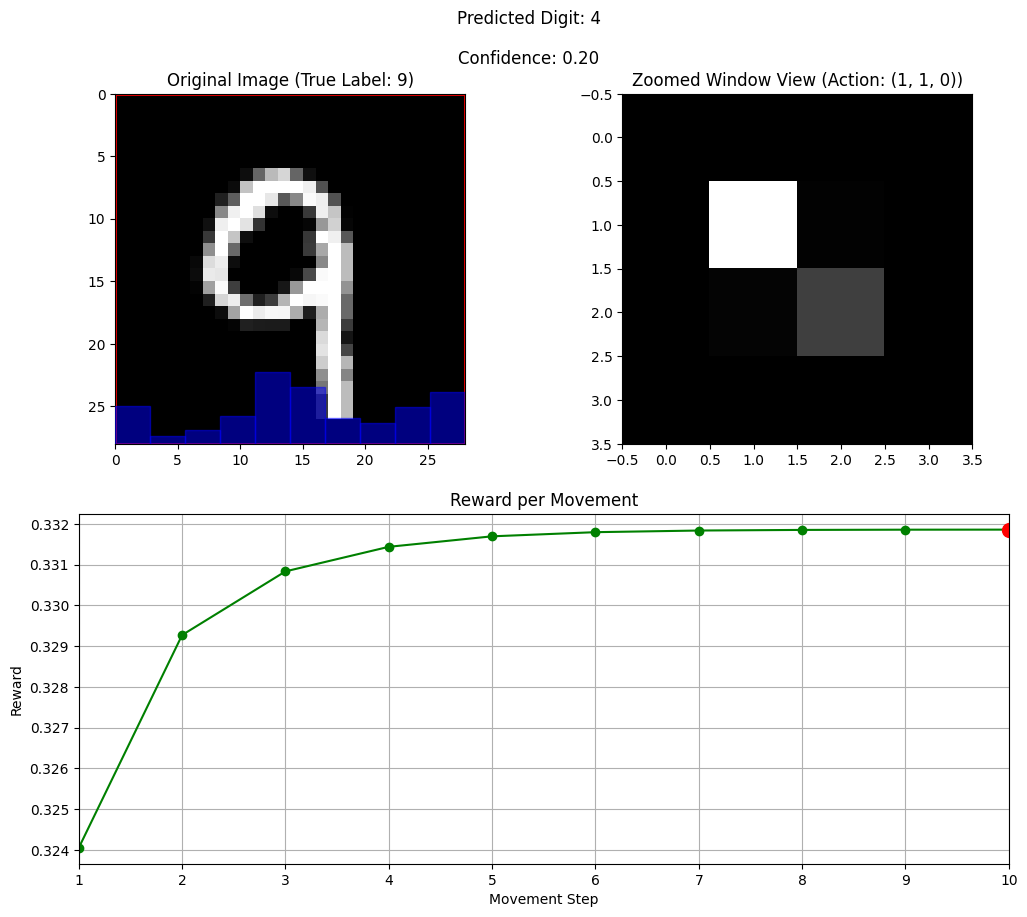

In [6]:
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from torchvision import datasets, transforms
from matplotlib.animation import FFMpegWriter
import torch
import torch.nn.functional as F

# Assume CONFIG, Environment, DTAgent, and DecisionTransformer are defined and imported.

def run_episode_eval(env, agent, state_size,
                     seq_length=CONFIG["seq_length"],
                     epsilon_const=CONFIG["epsilon_const"],
                     episode_id=100):
    """
    Runs one evaluation episode and records states, actions, prediction probabilities, and rewards.
    Returns a dictionary with episode data.
    """
    state = env.reset()
    image_id = env.current_index  # record image index
    # For the first token, use zeros for movement (3) and reward (1)
    init_token = np.concatenate([state, np.zeros(3), np.zeros(1)])
    tokens = [init_token]
    states_record = [state.tolist()]
    actions_record = []
    prediction_probs_record = []
    rewards_record = []  # record predicted reward per movement
    label = env.image_label
    predicted_digit = None

    for t in range(seq_length):
        # Pad the token sequence to length=seq_length
        current_seq = tokens.copy()
        while len(current_seq) < seq_length:
            current_seq.append(current_seq[-1])
        token_seq_tensor = torch.tensor(np.array(current_seq), dtype=torch.float32)\
                              .unsqueeze(0).to(agent.device)
        action, predicted_digit, digit_logits, action_index, predicted_reward = agent.select_action(token_seq_tensor)
        new_state, done, gt_label = env.step(action)

        # Get prediction probabilities from the digit head
        digit_probs = F.softmax(digit_logits, dim=-1).cpu().detach().numpy().tolist()

        states_record.append(new_state.tolist())
        actions_record.append(action)
        prediction_probs_record.append(digit_probs)
        rewards_record.append(predicted_reward)  # record the reward for this movement

        # Create new token: new_state + action (3 values) + predicted reward (1 value)
        movement_array = np.array(action, dtype=np.float32)
        reward_array = np.array([predicted_reward], dtype=np.float32)
        new_token = np.concatenate([new_state, movement_array, reward_array])
        tokens.append(new_token)

        if done:
            break

    # Ensure records have exactly seq_length entries where needed
    while len(states_record) < seq_length + 1:
        states_record.append(states_record[-1])
    while len(actions_record) < seq_length:
        actions_record.append(actions_record[-1])
    while len(prediction_probs_record) < seq_length:
        prediction_probs_record.append(prediction_probs_record[-1])
    while len(rewards_record) < seq_length:
        rewards_record.append(rewards_record[-1])

    episode_data = {
        'predicted_digit': predicted_digit,
        'true_label': label,
        'states': states_record,           # length: seq_length+1 (initial state + steps)
        'actions': actions_record,         # length: seq_length
        'prediction_probs': prediction_probs_record,  # length: seq_length
        'rewards': rewards_record,         # list of rewards per movement
        'image_id': image_id,
        'episode': episode_id
    }
    return episode_data

def visualize_episode(episode_data, test_images):
    """
    Visualizes a single episode.
    Expects episode_data to have keys: 'image_id', 'states', 'actions', 'true_label',
    'prediction_probs', 'rewards', 'predicted_digit', and 'episode'.
    """
    image_id = episode_data['image_id']
    states = episode_data['states']
    actions = episode_data['actions']
    true_label = episode_data['true_label']
    prediction_probs = episode_data['prediction_probs']
    rewards = episode_data['rewards']
    predicted_digit = episode_data['predicted_digit']

    # Final confidence is the maximum probability from the last time step.
    final_confidence = max(prediction_probs[-1])
    image = test_images[image_id]  # Test images are assumed in the range [0,1]

    # Set up the figure with three subplots:
    # - ax1: Original image with an inset bar chart for digit probabilities.
    # - ax2: Zoomed window view.
    # - ax3: Reward per movement plot.
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, :])

    base_size = CONFIG["BASE_IMAGE_SIZE"]
    ax1.imshow(image, cmap='gray', extent=[0, base_size, base_size, 0])
    ax1.set_title(f"Original Image (True Label: {true_label})")

    # Create an inset axis on ax1 for the probability bar chart.
    prob_ax = ax1.inset_axes([0, 0, 1, 1])
    prob_ax.set_xlim(0, 10)
    prob_ax.set_ylim(0, 1)
    prob_ax.axis('off')

    # Calculate bar width so that 10 bars fit in the image width.
    bar_width = 1
    bar_container = prob_ax.bar(
        np.arange(10) * bar_width + bar_width/2,
        np.zeros(10),
        width=bar_width,
        align='center',
        alpha=0.5
    )

    ax2.set_title("Zoomed Window View")
    ax3.set_title("Reward per Movement")
    ax3.set_xlabel("Movement Step")
    ax3.set_ylabel("Reward")

    # Display final predicted digit and confidence at the top of the figure.
    fig.text(0.5, 0.95, f'Predicted Digit: {predicted_digit}', ha='center', fontsize=12)
    fig.text(0.5, 0.91, f'Confidence: {final_confidence:.2f}', ha='center', fontsize=12)

    def animate(i):
        # Update the zoomed view subplot and rectangle on original image.
        state = np.array(states[i+1])
        action = actions[i]
        # Assuming that the zoom level is stored at index 16 (after the 4x4 window view)
        zoom_level = state[16] if len(state) > 16 else 1  # fallback in case of different state size
        probs = prediction_probs[i]

        # Update zoomed view (first 16 values form a 4x4 window view)
        ax2.cla()
        window_view = state[:16].reshape((4, 4))
        ax2.imshow(window_view, cmap='gray', interpolation='nearest')
        ax2.set_title(f"Zoomed Window View (Action: {action})")

        # Remove previous rectangle annotations from ax1.
        for patch in reversed(ax1.patches):
            patch.remove()

        # Draw rectangle on the original image to indicate the zoom window.
        rect_width = rect_height = 4 * zoom_level
        center = base_size // 2
        # Last two values in state vector indicate window offset (from center)
        x_offset = state[-2]
        y_offset = state[-1]
        x_pos = center + x_offset - rect_width / 2
        y_pos = center + y_offset - rect_height / 2
        rect = plt.Rectangle((x_pos, y_pos), rect_width, rect_height, linewidth=2, edgecolor='r', facecolor='none')
        ax1.add_patch(rect)

        # Update the probability bars in the inset axis.
        for bar, height in zip(bar_container, probs):
            bar.set_height(height)
            bar.set_color('blue')

        # Update reward per movement plot:
        ax3.cla()
        steps = np.arange(1, len(rewards) + 1)
        ax3.plot(steps, rewards, marker='o', color='green')
        ax3.set_title("Reward per Movement")
        ax3.set_xlabel("Movement Step")
        ax3.set_ylabel("Reward")
        ax3.set_xlim(1, len(rewards))
        # Highlight the current step's reward
        current_reward = rewards[i]
        ax3.plot(i+1, current_reward, marker='o', markersize=10, color='red')
        ax3.grid(True)
        return []

    ani = animation.FuncAnimation(fig, animate, frames=len(actions), interval=500, blit=False, repeat=False)
    writer = FFMpegWriter(fps=2, metadata=dict(artist='Me'), bitrate=1800)
    ani.save(f"episode_{episode_data['episode']}_visualization.mp4", writer=writer)
    plt.show()

def main():
    # Load MNIST test dataset using CONFIG values.
    transform = transforms.Compose([transforms.ToTensor()])
    test_dataset = datasets.MNIST(root=CONFIG["mnist_root"], train=False, download=True, transform=transform)
    test_images_all = test_dataset.data.numpy().astype(np.float32) / 255.0

    # Randomly select a test image from the full test set.
    import random  # ensure random is imported if not already
    random_idx = random.randrange(len(test_dataset))
    print(f"Selected random test image index: {random_idx}")
    test_image = test_images_all[random_idx:random_idx+1]  # slice a single image
    test_label = test_dataset.targets.numpy()[random_idx:random_idx+1]

    # Create a test environment with just this single test image in test mode.
    test_env = Environment(test_image, test_label, mode="test")
    state_size = test_env.get_state().shape[0]
    seq_length = CONFIG["seq_length"]

    # Initialize DTAgent and load trained model weights.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    agent = DTAgent(state_size=state_size, device=device)
    agent.model.load_state_dict(torch.load("dt_model_weights.pth", map_location=device))
    agent.model.eval()
    agent.epsilon = 0.0  # Fully greedy for evaluation

    # Run one evaluation episode.
    episode_data = run_episode_eval(test_env, agent, state_size, seq_length=seq_length, episode_id=0)

    # Visualize the episode.
    # Note: Since our environment now contains only one image, pass test_image directly.
    visualize_episode(episode_data, test_image)

if __name__ == "__main__":
    main()
